### Table of Contents

* [1. Préparation du notebook](#chapter1)


* [2. Chargement du dataset `application_train`](#chapter2)
    
    * [2.1 Traitements de valeurs manquantes et Standardisation du jeu de données](#section2.1)
        
    * [2.2 Séparation des données train et test](#section2.2)
    
* [3. Modélisation](#chapter3)
    
    * [3.1 Modèle de base Dummy ](#section3.1)
    
    * [3.2 Logistic Regressor](#section3.2)
    
        * [3.2.1 Logistic Regression (max_iter=500, solver='sag')](#section3.2.1)
        
        * [3.2.2 Avec SelectKBest](#section3.2.2)
        
        * [3.2.3 Avec GridSearch](#section3.2.3)
        
    * [3.3 Random Forest et Light GBM](#section3.3)
    
        * [3.3.1 Sans GridSearch](#section3.3.1)
        
        * [3.3.2 Light GBM avec GridSearch](#section3.3.2)
        
        * [3.3.3 Features importance](#section3.3.3)
    
        * [3.3.4 Interprétation avec SHAP](#section3.3.4)
        
        
       
        * [3.3.5 Interprétation avec LIME](#section3.3.5)
       

# 1. Préparation du notebook <a class="anchor" id="chapter1"></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#import missingno as msn

import scipy.stats as st

import math

import random

import timeit
import time
import datetime

import sklearn

from sklearn.preprocessing import StandardScaler

from sklearn import model_selection

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GroupKFold, StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
                                  
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,\
                            roc_auc_score, RocCurveDisplay, average_precision_score,\
                            ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import SMOTE
from collections import Counter

#import squarify

from termcolor import colored

from colorama import Fore, Back, Style

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#from yellowbrick.classifier import ConfusionMatrix

In [2]:
def namestr(obj, namespace): 
    return [name for name in namespace if namespace[name] is obj]

font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,}

def missing_cells(data):
    return data.isna().sum().sum()

def missing_cells_percent(data):
    return data.isna().sum().sum()*100/(data.size)

def summary_columns(data):
    summary = pd.DataFrame(columns=['Variable name', 'Variable type', 'Missing values', '% Missing'])
    summary['Variable name'] = data.columns
    summary['Variable type'] = list(pd.DataFrame(data.dtypes)[0])
    missing = list()
    percent_missing = list()
    for var in data.columns:
        nb_missing = missing_cells(data[var])
        pc_missing = missing_cells_percent(data[var])
        missing.append(nb_missing)
        percent_missing.append(pc_missing)
    summary['Missing values'] = list(missing)
    summary['% Missing'] = list(percent_missing)
    
    # On range de manière décroissante 
    summary = summary[summary.iloc[:,1] != 0].sort_values('% Missing', ascending=False).round(1)
    
    return summary

def plot_nan_percent(df_nan, title_name, tight_layout = True, figsize = (20,8), grid = False, rotation = 90):
    '''
    Function to plot Bar Plots of NaN percentages for each Column with missing values
    
    Inputs:
        df_nan: 
            DataFrame of NaN percentages
        title_name: 
            Name of table to be displayed in title of plot
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        figsize: tuple, default = (20,8)
            Figure size of plot    
        grid: bool, default = False
            Whether to draw gridlines to plot or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels
    '''
    #checking if there is any column with NaNs or not.
    if df_nan['% Missing'].sum() != 0:
        print(f"Le nombre de colonnes ayant Nan : {df_nan[df_nan['% Missing'] != 0].shape[0]} colonnes")
        
        #plotting the Bar-Plot for NaN percentages (only for columns with Non-Zero percentage of NaN values)
        plt.figure(figsize = figsize, tight_layout = tight_layout)
        sns.barplot(x= 'Variable name', y = '% Missing', data = df_nan[df_nan['% Missing'] > 0])
        plt.xticks(rotation = rotation)
        plt.xlabel('Column Name')
        plt.ylabel('Percentage of NaN values')
        plt.title(f'Percentage of NaN values in {title_name}')
        if grid:
            plt.grid()
        plt.show()
    else:
        print(f"Le dataset {title_name} ne contient pas de NaN.")

def description_dataset(data, name):
    ''' Return the description of a dataset
            Parameters: data: dataframe
                        name: 
            
            Returns: the 3 first line of the dataframe
                     the shape, the types, the number of null values,
                     the number of unique values, the number of duplicated values
            '''
    print('=='*20 + name + '=='*20 )
    print('\n')
    
    print(f'Taille :  {data.shape}')
    print('\n')
    
    print(Fore.RED + "Valeurs différentes par variables : ")
    print(Style.RESET_ALL)
    for col in data:
        if data[col].nunique() < 30:
            print (f'{col} ( type de variable : {data[col].dtype} ) : {data[col].unique()}')
        else : 
            print(f'{col} ( type de variable : {data[col].dtype} ) contient {data[col].nunique()} valeurs différentes')
    print('\n')
    
    print(f"Nombre de doublons : {data.duplicated().sum()}")
    print('\n')
    
    print("Valeurs manquantes par colonnes (%): ")
    table = summary_columns(data)
    display(table.head(50))
    print('\n')

    plot_nan_percent(table, name, tight_layout = True, figsize = (20,8), grid = False, rotation = 90)

# Fonction pour supprimer les doublons de lignes dans une dataframe
def drop_doublons(data):
    
    # Création d'une variable indiquant la présence de lignes dupliquées dans la dataframe
    nbre_lignes_dupliq_av = data[data.duplicated(keep=False)] 
    
    print("Liste des lignes dupliquées pour chaque colonne de la dataframe :")
    display(nbre_lignes_dupliq_av)
    
    # Suppression des valeurs dupliquées
    data.drop_duplicates(keep="first", inplace=True)
    
    # Création d'une variable indiquant la présence de lignes dupliquées dans la dataframe
    nbre_lignes_dupliq_ap = data[data.duplicated(keep=False)] 

    return nbre_lignes_dupliq_ap

In [3]:
def chargement_dataset(chemin):
    data = pd.read_csv(chemin, sep=',', low_memory=False)
    display(data.head())
    print(data.info())
    return data

def merge_dataset(data1, data2, col):
    data1 = data1.merge(data2, on=col, how='left')
    display(data1.head())
    print(data1.info())
    return data1

In [4]:
def plots_uniVariable(monData, var, title1, title2, title3):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
    fig.suptitle(title1)

    sns.histplot(ax=axes[0], x=var, data=monData, kde=True)
    axes[0].set_title(title2)

    sns.boxplot(ax=axes[1], x=var, data=monData)
    axes[1].set_title(title3)

    plt.show()
    return

In [5]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# 2. Chargementdu dataset `application_train`  <a class="anchor" id="chapter2"></a>

Les données **Home Credit** sont disponibles à l'adresse suivante: https://www.kaggle.com/c/home-credit-default-risk/data 

Le jeu de données contient 7 tables, plus une table des descriptions des différentes variables.

 - application_{train|test}.csv : 
  -  Il s’agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET). Ce sont des données statiques pour toutes les applications. 
  -  Une ligne représente un prêt dans l'échantillon de données, identifié par la variable `SK_ID_CURR`.
  -  La variable `TARGET` contient, soit la valeur 0 (le prêt a été remboursé à temps), soit la valeur 1 (le prêt n'a pas été remboursé à temps).

 - bureau.csv :
  -  Tous les crédits antérieurs des clients fournis par d'autres institutions financières qui ont été signalés au bureau de crédit (pour les clients qui ont un prêt dans l'échantillon).
  -  Pour chaque prêt de l'échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le bureau de crédit avant la date de la demande.

 - bureau_balance.csv :
  -  Soldes mensuels des crédits précédents au Credit Bureau.
  -  Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent signalé au bureau de crédit - c'est-à-dire que le tableau a contient des lignes correspondant à X prêts dans l'échantillon multipliés par Y crédits précédents relatifs à Z mois où nous avons un historique observable pour les crédits précédents.

 - POS_CASH_balance.csv :
  -  Instantanés du solde mensuel des POS (points de vente) précédents et des prêts en espèces que le demandeur avait avec Home Credit.
  -  Ce tableau comporte une ligne pour chaque mois d’historique de chaque crédit précédent dans le crédit immobilier (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a contient des lignes correspondant à X prêts dans l'échantillon multipliés par Y crédits précédents relatifs à Z mois où nous avons un historique observable pour les crédits précédents.

 - credit_card_balance.csv :
  -  Instantanés du solde mensuel des cartes de crédit précédentes que le demandeur a avec Home Credit.
  -  Ce tableau a une ligne pour chaque mois d’historique de chaque crédit précédent dans le crédit immobilier (crédit à la consommation et prêts de trésorerie) lié aux prêts dans notre échantillon - c’est-à-dire que le tableau a (#loans dans l’échantillon * # de cartes de crédit antérieures relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.

 - previous_application.csv :
  -  Toutes les demandes précédentes de prêts de crédit immobilier de clients qui ont des prêts dans notre échantillon.
  -  Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données. Chaque prêt en cours dans l'application (application_train/test) peut avoir plusieurs des demandes/prêts antérieur(e)s. Chaque demande de prêt antérieure est identifiée par la variable `SK_ID_PREV`.

 - installments_payments.csv :
  -  Historique de remboursement des crédits précédemment décaissés en Home Credit  liés aux prêts de notre échantillon.
  -  Il y a une ligne pour chaque paiement effectué plus une ligne pour chaque paiement manqué.
  -  Une ligne équivaut à un versement d’un versement ou à un versement correspondant à un versement d’un crédit immobilier précédent lié à des prêts de notre échantillon.

 - HomeCredit_columns_description.csv :
   -  Ce fichier contient les descriptions des colonnes des différents fichiers de données.

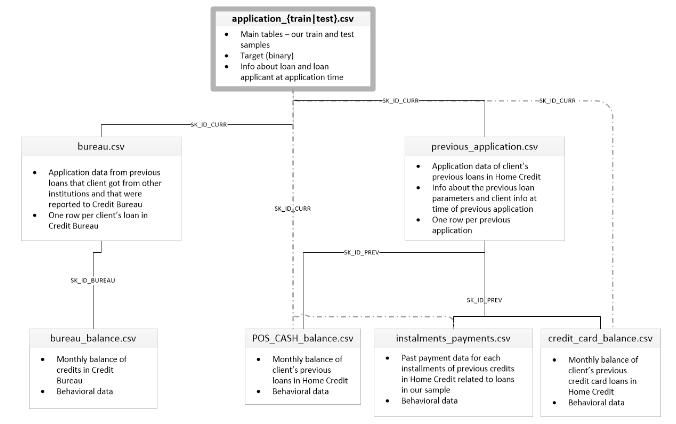

In [6]:
# Datast de train après les regroupement des fichiers
data_train_before_imp_std = chargement_dataset('C:\\Users\\karis\\Downloads\\P7_Dataset_train.csv')

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_LATE_PAYMENT_MIN,CC_LATE_PAYMENT_MAX,CC_LATE_PAYMENT_MEAN,CC_LATE_PAYMENT_SUM,CC_LATE_PAYMENT_VAR,CC_DRAWING_LIMIT_RATIO_MIN,CC_DRAWING_LIMIT_RATIO_MAX,CC_DRAWING_LIMIT_RATIO_MEAN,CC_DRAWING_LIMIT_RATIO_SUM,CC_COUNT
0,100002,1.0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,6.0
4,100007,0.0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307506 entries, 0 to 307505
Columns: 841 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(693), int64(148)
memory usage: 1.9 GB
None


L'identifiant de ce dataset est la variable `SK_ID_CURR`.

La variable `TARGET` représente la status pour la défaillance de crédit: 0 pour les emprunteurs non défaillants (91,9%), 1 pour les emprunteurs défaillances (8,1%).

### 2.1 Traitements de valeurs manquantes et Standardisation du jeu de données<a class="anchor" id="section2.1"></a>

In [102]:
# Supprimmer de colonnes avec au moins 20 % de valeurs NaN

column_with_nan = data_train.columns[data_train.isnull().any()]

for column in column_with_nan:
    if data_train[column].isnull().sum()*100.0/data_train.shape[0] > 80:
        data_train.drop(column,1, inplace=True)
        
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307506 entries, 0 to 307505
Columns: 804 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(656), int64(148)
memory usage: 1.8 GB


In [23]:
data_index_TARGET = data_train[['SK_ID_CURR','TARGET']]
data_train.drop(columns=['SK_ID_CURR','TARGET'], inplace = True)

In [103]:
data_index_TARGET

,SK_ID_CURR,TARGET
0,100002,1.0
1,100003,0.0
2,100004,0.0
3,100006,0.0
4,100007,0.0
...,...,...
307501,456251,0.0
307502,456252,0.0
307503,456253,0.0
307504,456254,1.0


In [104]:
data_train

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_LIMIT_USE_MEAN,CC_LIMIT_USE_SUM,CC_LIMIT_USE_VAR,CC_LATE_PAYMENT_MIN,CC_LATE_PAYMENT_MAX,CC_LATE_PAYMENT_MEAN,CC_LATE_PAYMENT_SUM,CC_LATE_PAYMENT_VAR,CC_DRAWING_LIMIT_RATIO_SUM,CC_COUNT
0,100002,1.0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307501,456251,0.0,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307502,456252,0.0,1,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307503,456253,0.0,1,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307504,456254,1.0,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
from sklearn.impute import KNNImputer, SimpleImputer

# Imputation des valeurs NaN par la médiane
data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
imputer = SimpleImputer(strategy = 'median')
data_train_Imputed = imputer.fit_transform(data_train)
data_train_Imputed = pd.DataFrame(data_train_Imputed, columns=data_train.columns)

In [106]:
# Standardisation des données 
from sklearn.preprocessing import MinMaxScaler

# Fonction pour standardisation des données du dataset
def std_dataset(df_in, method_std):
    df_in_std = pd.DataFrame(method_std.fit_transform(df_in), columns = df_in.columns)
    
    return df_in_std

scaler = MinMaxScaler()
data_train_Imputed_std = std_dataset(data_train_Imputed, scaler)

In [30]:
# Remettre les comonnes ['SK_ID_CURR','TARGET']
data_train_Imp_std = pd.concat([data_index_TARGET, data_train_Imputed_std], axis=1)

In [32]:
data_train_Imp_std

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_LATE_PAYMENT_MIN,CC_LATE_PAYMENT_MAX,CC_LATE_PAYMENT_MEAN,CC_LATE_PAYMENT_SUM,CC_LATE_PAYMENT_VAR,CC_DRAWING_LIMIT_RATIO_MIN,CC_DRAWING_LIMIT_RATIO_MAX,CC_DRAWING_LIMIT_RATIO_MEAN,CC_DRAWING_LIMIT_RATIO_SUM,CC_COUNT
0,100002,1.0,0.0,0.0,0.009839,0.090287,0.090032,0.077441,0.256321,0.888839,...,0.0,0.0,0.0,0.0,0.0,0.0,0.067568,0.01942,0.011219,0.109948
1,100003,0.0,1.0,0.0,0.013594,0.311736,0.132924,0.271605,0.045016,0.477114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.067568,0.01942,0.011219,0.109948
2,100004,0.0,0.0,1.0,0.002328,0.022472,0.020025,0.023569,0.134897,0.348534,...,0.0,0.0,0.0,0.0,0.0,0.0,0.067568,0.01942,0.011219,0.109948
3,100006,0.0,1.0,0.0,0.006084,0.066837,0.109477,0.063973,0.107023,0.350846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.067568,0.01942,0.000000,0.026178
4,100007,0.0,0.0,0.0,0.005333,0.116854,0.078975,0.117845,0.392880,0.298591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.067568,0.01942,0.011219,0.109948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307501,456251,0.0,0.0,0.0,0.007335,0.052360,0.101176,0.046016,0.446855,0.896392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.067568,0.01942,0.011219,0.109948
307502,456252,0.0,1.0,0.0,0.002579,0.056067,0.040505,0.046016,0.344429,0.251071,...,0.0,0.0,0.0,0.0,0.0,0.0,0.067568,0.01942,0.011219,0.109948
307503,456253,0.0,1.0,0.0,0.007085,0.157969,0.110618,0.135802,0.065247,0.578523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.067568,0.01942,0.011219,0.109948
307504,456254,1.0,1.0,0.0,0.008086,0.081175,0.072499,0.069585,0.069553,0.747914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.067568,0.01942,0.011219,0.109948


In [33]:
# Enregister le data_train_Imp_std
data_train_Imp_std.to_csv('C:\\Users\\karis\\Downloads\\P7_Dataset_train_Imputed_std.csv', index=False)

In [34]:
del data_train, data_train_Imputed, data_train_Imputed_std

In [6]:
#Dataset de train après les traitements
data_train = pd.read_csv('C:\\Users\\LeMuon\\Downloads\\P7_Dataset_train_Imputed_std.csv', sep=",", 
                         index_col='SK_ID_CURR', encoding ='utf-8')
data_train

,TARGET,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CC_LATE_PAYMENT_MIN,CC_LATE_PAYMENT_MAX,CC_LATE_PAYMENT_MEAN,CC_LATE_PAYMENT_SUM,CC_LATE_PAYMENT_VAR,CC_DRAWING_LIMIT_RATIO_MIN,CC_DRAWING_LIMIT_RATIO_MAX,CC_DRAWING_LIMIT_RATIO_MEAN,CC_DRAWING_LIMIT_RATIO_SUM,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0.0,0.0,0.009839,0.090287,0.090032,0.077441,0.256321,0.888839,0.964437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.067568,0.01942,0.011219,0.109948
100003,0.0,1.0,0.0,0.013594,0.311736,0.132924,0.271605,0.045016,0.477114,0.933676,...,0.0,0.0,0.0,0.0,0.0,0.0,0.067568,0.01942,0.011219,0.109948
100004,0.0,0.0,1.0,0.002328,0.022472,0.020025,0.023569,0.134897,0.348534,0.987439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.067568,0.01942,0.011219,0.109948
100006,0.0,1.0,0.0,0.006084,0.066837,0.109477,0.063973,0.107023,0.350846,0.830337,...,0.0,0.0,0.0,0.0,0.0,0.0,0.067568,0.01942,0.000000,0.026178
100007,0.0,0.0,0.0,0.005333,0.116854,0.078975,0.117845,0.392880,0.298591,0.830393,...,0.0,0.0,0.0,0.0,0.0,0.0,0.067568,0.01942,0.011219,0.109948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,0.0,0.0,0.0,0.007335,0.052360,0.101176,0.046016,0.446855,0.896392,0.986824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.067568,0.01942,0.011219,0.109948
456252,0.0,1.0,0.0,0.002579,0.056067,0.040505,0.046016,0.344429,0.251071,0.907995,...,0.0,0.0,0.0,0.0,0.0,0.0,0.067568,0.01942,0.011219,0.109948
456253,0.0,1.0,0.0,0.007085,0.157969,0.110618,0.135802,0.065247,0.578523,0.557782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.067568,0.01942,0.011219,0.109948


### 2.2 Séparation des données train et test <a class="anchor" id="section2.2"></a>

In [7]:
from sklearn.model_selection import train_test_split

y = data_train['TARGET']
data1 = data_train.copy(deep = True)
data1.drop(['TARGET'], axis = 1, inplace = True)

X_train, X_test, y_train, y_test = train_test_split(data1,
                                                    data_train['TARGET'],
                                                    train_size=0.8, 
                                                    stratify=y,
                                                    random_state=42)

print('train size :', X_train.shape, y_train.shape)
print('test size :', X_test.shape, y_test.shape)

train size : (246004, 839) (246004,)
test size : (61502, 839) (61502,)


In [24]:
# Distribution de la classe TARGET sur le train
perc_train_target_1 = round(((y_train == 1.).sum() / y_train.shape[0] *100), 1)
perc_train_target_0 = round(100 - perc_train_target_1, 1)
print("Pourcentage train classe Target - valeur 0: " + str(perc_train_target_0) + ' %')
print("Pourcentage train classe Target - valeur 1: " + str(perc_train_target_1) + ' %')

Pourcentage train classe Target - valeur 0: 91.9 %
Pourcentage train classe Target - valeur 1: 8.1 %


In [9]:
# Distribution de la classe TARGET sur test
perc_test_target_1 = round(((y_test == 1.).sum() / y_test.shape[0] *100), 1)
perc_test_target_0 = round(100 - perc_test_target_1, 1)
print("Pourcentage test classe Target - valeur 0: " + str(perc_test_target_0) + ' %')
print("Pourcentage test classe Target - valeur 1: " + str(perc_test_target_1) + ' %')

Pourcentage test classe Target - valeur 0: 91.9 %
Pourcentage test classe Target - valeur 1: 8.1 %


# 3. Modélisation par les baselines : Dummy et LogisticRegressor <a class="anchor" id="chapter3"></a>

**Métrique adaptée au problème de la banque:**

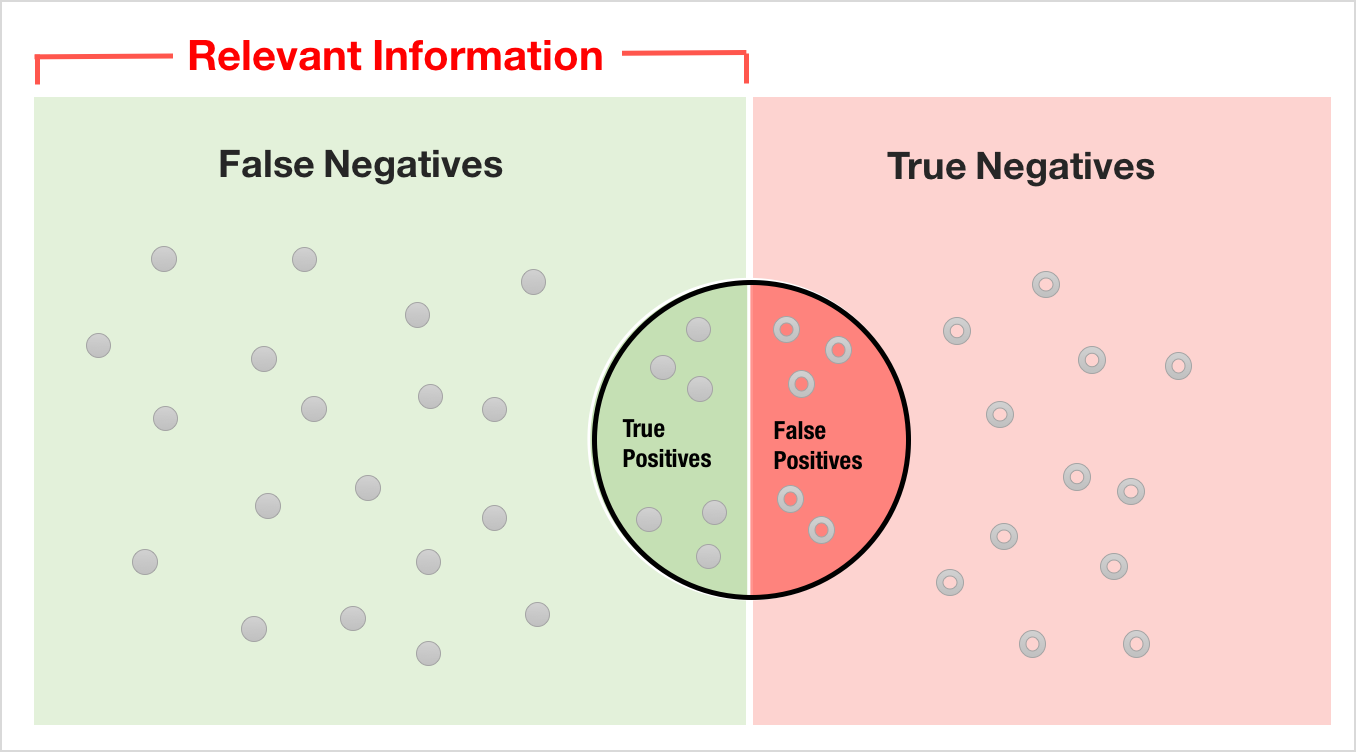

 - **True Negative (TN)**: personnes prédites comme non-défaillantes, et qui sont réellement non-défaillantes. (LE PRET N'EST PAS ACCORDE ET LE CLIENT NE PEUT PAS REMBOURSER LE PRET.)<br><br>

 - **False Negative (FN)**: personnes qui ont été prédites comme non défaillantes par le modèle mais qui étaient en fait des défaillants. (LE PRET EST ACCORDE ET LE CLIENT PEUT REMBOURSER LE PRET.)<br><br>

 - **False Positive (FP)**: personnes qui ont été prédites comme défaillantes par le modèle mais qui étaient en fait non défaillants. (LE PRET N'EST PAS ACCORDE MAIS LE CLIENT PEUT REMBOURSE LE PRET.)<br><br>

 - **True Positive (TP)**: personnes prédites comme défaillantes, et qui sont rééllement défaillantes. (LE PRET EST ACCORDE MAIS LE CLIENT NE PEUT PAS REMBOURSER LE PRET.)

**Les métriques:**

 - **Exactitude:** <br>
 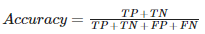

 - **Précision:**<br>
 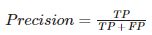

 - **Rappel:**<br>
 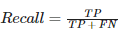

 - **F-Score:**<br>
 

 - **Courbe ROC (Receiver Operator Characteristic):** est construite en traçant le taux positif vrai (TPR) contre le taux faux positif (FPR). 
 
  -  Le taux positif réel est la proportion d’observations qui ont été correctement prédites positives parmi toutes les observations positives (TP/(TP + FN)). 
  -  Le taux de faux positifs est la proportion d’observations qui sont incorrectement prédites positives parmi toutes les observations négatives (FP/(TN + FP)).
  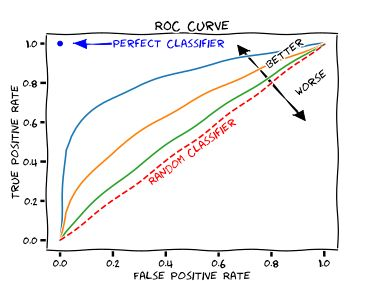
  
La courbe ROC montre le compromis entre la sensibilité (ou TPR) et la spécificité (1-FPR). Les classificateurs qui donnent des courbes plus proches du coin supérieur gauche indiquent une meilleure performance. En tant que ligne de base, un classificateur aléatoire devrait donner des points situés le long de la diagonale (FPR = TPR)., Plus la courbe se rapproche de la diagonale de 45 degrés de L’Espace ROC, moins le test est précis.
 
 

 - **Métrique personnalisée:**<br>
        
  -  TN ==> prêt accordé avec de rembousement, gagne d'argent pour la banque ==> coeff_tn = 5
  -  TP ==> refus de prêt ==> coeff_tp = 1
  -  FN ==> prêt accordé mais pas de rembousement, perte d'argent pour la banque ==> coeff_fn = -10
  -  FP ==> client perdu, perte d'argent pour la banque ==> coeff_fp = -1

In [8]:
# Fonction pour calculer métrique personnalisée - fonction de coût
[coeff_tn, coeff_fp, coeff_fn, coeff_tp] = [5, -1, -50, 5] #[10, -1, -100, 0] 

def score_pers(tn, fp, fn, tp, coeff_tn, coeff_fp, coeff_fn, coeff_tp): # 10, -1, -100, 0

    total = (coeff_tn*tn + coeff_fp*fp + coeff_fn*fn + coeff_tp*tp)

    #calcul du gain maximal que peut avoir la banque quand il n'y a pas de perte d'argent. 
    #C'est à dire que le modèle ne détecte que TN et les TP.
    max_gain = (tn + fp)*coeff_tn + (tp + fn)*coeff_tp

    #calcul du gain minimal (perte) que peut avoir la banque quand il n'y a pas de gain d'argent. 
    #C'est à dire que le modèle ne détecte que FN et les FP.
    min_gain = (tn + fp)*coeff_fp + (tp + fn)*coeff_fn

    #normalisation min-max feature scalling : score= (tot-min)/(max-min) 
    score = (total - min_gain)/(max_gain - min_gain)

    return score

In [9]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,\
                            confusion_matrix, roc_curve, roc_auc_score, RocCurveDisplay, average_precision_score,\
                            ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay

scoring = {'roc_auc'  : 'roc_auc',
           'accuracy' : 'accuracy',
           'precision': make_scorer(precision_score, zero_division=0),
           'recall'   : 'recall',
           'f1'       : 'f1'}

random_state = 42

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

## 3.1 Modèle de base Dummy <a class="anchor" id="section3.1"></a> 

https://towardsdatascience.com/interpreting-roc-curve-and-roc-auc-for-classification-evaluation-28ec3983f077

In [11]:
from sklearn.dummy import DummyClassifier

# Modèle baseline
model = DummyClassifier(strategy='most_frequent')

In [10]:
# Fonction pour modelisation simple baseline
def evaluation_model_without_GS(model, model_name, X_train, y_train, X_test, y_test,
                                cv, random_state, scoring, # Validation croisée
                                ) : #threshold='ROC') : #, class_weight_flag):
    
    print("- - - - - Modélisation par " + model_name )
    t0 = time.time()
    
    # Entraînement et prédiction du modèle sur le dataset train
    print(f"Entraînement et prédictions du modèle {model_name}.")
    model.fit(X_train, y_train)
    
    print("cross_val_score :", cross_val_score(model, X=X_train, y=y_train, cv=cv, scoring="roc_auc", verbose=2))
    
    #Temps d'exécution
    temps = time.time() - t0

    # Prédictions sur les données test
    y_pred = model.predict(X_test)    
    ###############
    y_proba = model.predict_proba(X_test)[:, 1]
        
    # Calcul des métriques d'évaluation :
    accuracy = accuracy_score(y_test, y_pred)
    # Métriques pour chaque classe 0 et 1 (precision, recall (sensitivity et specificity), f1_score)
    #precision = precision_score(y_test, y_pred, average='binary') #binary car ici 0 ou 1 si plusieurs label c'est weighted
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    ###############
    
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
   
    # Métriques pour chaque classe 0 et 1 (precision, recall (sensitivity et specificity), fscore)
    #metrics_by_class = metrics.precision_recall_fscore_support(y_test,y_pred)
    
    print(colored("Les métriques d'évaluation : \n ", 'red'))  

    print(colored('Le score AUC pour {} : {}.\n'.format(model_name, roc_auc), 'blue'))

    print(colored('L\'accuracy score de {} : {}.\n'.format(model_name, accuracy), 'blue'))
    
    print(colored('Le score de précision de {} : {}.\n'.format(model_name, precision), 'blue'))

    print(colored('Le score recall de {} : {}.\n'.format(model_name, recall), 'blue'))

    print(colored('Le score f1 est de {} : {}.\n'.format(model_name, f1), 'blue'))    
    
    # Métrique personnelle de métier    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
    score_pers1 = score_pers(tn, fp, fn, tp, coeff_tn, coeff_fp, coeff_fn, coeff_tp)        
    print(colored('Le score personnelle de métier pour {} : {}.\n'.format(model_name, score_pers1), 'blue'))
    
    #pr_auc = average_precision_score(y_test, y_proba[:,1])
           
    resultats_modele = pd.DataFrame({'Modèle' : [model_name],
                                     'roc_auc' : [roc_auc],
                                     'accuracy' : [accuracy],
                                     'precision' : [precision],
                                     'recall' : [recall],
                                     'f1' : [f1],
                                     'score_pers' : [score_pers1],
                                     'Temps' : [temps]})    
    
    # Rapport de classification
    classif_report = metrics.classification_report(y_test, y_pred)
    print("Rapport sur classification: ", classif_report, sep="\n")
    
     # Affichage du matrice de confusion et la courbe ROC     
    size = (12,12)
    fig = plt.figure(figsize=size)
  
    #Courbe ROC    
    ax1 = fig.add_subplot(221)
    ax1.title.set_text('Confusion Matrix')
    group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='RdPu')
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

    # Matrice de confusion    
    ax2 = fig.add_subplot(222)
    ax2.title.set_text('ROC Curve')
    fpr,tpr,_ = roc_curve(y_test, y_proba)#[:,1])    #pour la courbe ROC utilisation de la probabiilité d'être 1
    plt.plot(fpr, tpr, color='pink', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    plt.show()
 
    print('True negative = ', tn)
    print('False positive = ', fp)
    print('False negative = ', fn)
    print('True positive = ', tp)
    
    del t0
    
    return resultats_modele # conf_matrix, classif_report 


- - - - - Modélisation par Dummy Classifier
Entraînement et prédictions du modèle Dummy Classifier.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.7s
cross_val_score : [0.5 0.5 0.5 0.5 0.5]
Les métriques d'évaluation : 
 
Le score AUC pour Dummy Classifier : 0.5.

L'accuracy score de Dummy Classifier : 0.9192709180189262.

Le score de précision de Dummy Classifier : 0.0.

Le score recall de Dummy Classifier : 0.0.

Le score f1 est de Dummy Classifier : 0.0.

Le score personnelle de métier pour Dummy Classifier : 0.5540154532849254.



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.4s finished
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

Rapport sur classification: 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.46      0.50      0.48     61502
weighted avg       0.85      0.92      0.88     61502



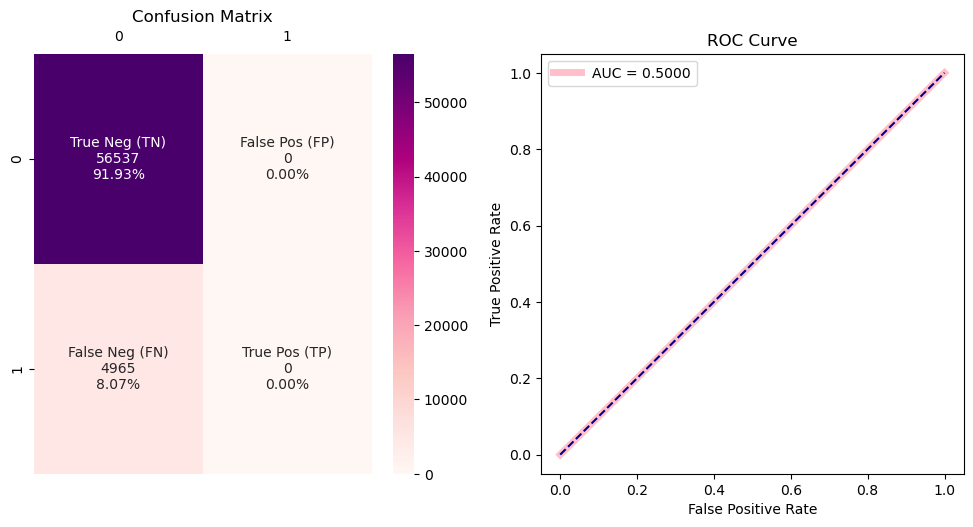

True negative =  56537
False positive =  0
False negative =  4965
True positive =  0


In [19]:
resultats_model = evaluation_model_without_GS(model, 'Dummy Classifier', 
                                              X_train, y_train, X_test, y_test,
                                              skfold, random_state, scoring)

In [20]:
display(resultats_model)

,Modèle,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Dummy Classifier,0.5,0.919271,0.0,0.0,0.0,0.554015,4.472085


## 3.2 Logistic Regression <a class="anchor" id="section3.2"></a> 

## 3.2.1 Logistic Regression (max_iter=500, solver='sag') <a class="anchor" id="section3.2.1"></a> 

On va tester le modèle **Logistic Regression** avec trois options:

 - Sans `class_weight`; <br>
 
 - Avec `class_weight`; <br>
 
 - Avec **SMOTE**.

 - **Sous-échantillonnage (undersampling):** Parmi les individus majoritaires, on en retire une partie afin d’accorder plus d’importance aux individus minoritaires. Cette approche permet de diminuer la redondance des informations apportées par le grand nombre d’individus majoritaires. <br><br>
 
 - **Sur-échantillonnage (oversampling):** Le nombre d’individus minoritaires est augmenté pour qu’ils aient plus d’importance lors de la modélisation.


https://kobia.fr/imbalanced-data-smote/

**SMOTE**( Synthetic Minority Oversampling TEchnique): est une méthode de suréchantillonnage des observations minoritaires. Pour éviter de réaliser un simple clonage des individus minoritaires, le SMOTE se base sur un principe simple : générer de nouveaux individus minoritaires qui ressemblent aux autres, sans être strictement identiques. Cela permet de densifier de façon plus homogène la population d’individus minoritaires.

Pour créer un individu synthétique, les étapes définies dans l’algorithme du SMOTE sont les suivantes :

  -  Sélectionner aléatoirement une observation minoritaire “initiale”.<br>
  -  Identifier ses k plus proches voisins parmi les observations minoritaires (où k est un paramètre défini par l’utilisateur).<br>
  -  Choisir aléatoirement l’un des k plus proches voisins.<br>
  -  Générer aléatoirement un coefficient 0<\alpha<1.<br>
  -  Créer un nouvel individu entre l’observation initiale et le plus proche voisin choisi, selon la valeur du coefficient . Par exemple, si \alpha = 0.5, le nouvel individu sera positionné à mi-chemin entre l’observation initiale et le plus proche voisin choisi.<br> 

C’est sur ces données transformées, auxquelles on a ajouté de faux individus synthétiques, que l’on va ensuite entraîner un modèle de Machine Learning.



In [19]:
#from imblearn.over_sampling import SMOTE
#from collections import Counter

# Paramétrage SMOTE
#smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=random_state, n_jobs=-1)

#X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#print('Dimensions du jeu de données initial : %s' % Counter(y_train))
#print("Dimensions du jeu de données d'entraînement suréchantillonné : %s" % Counter(y_train_smote))

In [13]:
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

# Fonction pour les modèles Logistic Regression
def evaluation_model_without_GS(model_name, X_train, y_train, X_test, y_test,
                                cv, random_state, scoring, method_imb) :
    
    print("- - - - - Modélisation par " + model_name )
    print("\n")
    t0 = time.time()
    
    # Modèle    
    if method_imb == 'class_weight' :
        model = LogisticRegression(C=10, max_iter=500, solver='sag', class_weight='balanced')
    if method_imb == 'None' :
        model = LogisticRegression(C=10, max_iter=500, solver='sag') 
        
    if method_imb == 'SMOTE' :
        model = imbpipeline(steps = [['smote', SMOTE(sampling_strategy='auto', k_neighbors=5, 
                                                     random_state=random_state, n_jobs=-1)],
                                     ['classifier', LogisticRegression(C=10, max_iter=500, solver='sag')]])
        
    print("- - - - - Modélisation par " + model_name + " with " + method_imb)
    print("\n")      
        
    print("Entraînement et prédictions du modèle.\n")
    model.fit(X_train, y_train)
    
    print("cross_val_score :", cross_val_score(model, X=X_train, y=y_train, cv=cv, scoring="roc_auc", verbose=2))
    print("\n")     
    #Temps d'exécution
    temps = time.time() - t0

    # Prédictions sur les données test
    y_pred = model.predict(X_test)
    
    ###############
    y_proba = model.predict_proba(X_test)[:, 1]
        
    # Calcul des métriques d'évaluation :
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    ###############
    
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    
    print(colored("Les métriques d'évaluation : \n ", 'red'))

    print(colored('Le score AUC pour {} avec {} : {}.\n'.format(model_name, method_imb, roc_auc), 'blue'))

    print(colored('L\'accuracy score de {} avec {} : {}.\n'.format(model_name, method_imb, accuracy), 'blue'))

    print(colored('Le score de précision de {} avec {} : {}.\n'.format(model_name, method_imb, precision), 'blue'))

    print(colored('Le score recall de {} avec {} : {}.\n'.format(model_name, method_imb, recall), 'blue'))

    print(colored('Le score f1 est de {} avecc {} : {}.\n'.format(model_name, method_imb, f1), 'blue'))    
    
    # Métrique personnelle de métier
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
    score_pers1 = score_pers(tn, fp, fn, tp, coeff_tn, coeff_fp, coeff_fn, coeff_tp)
    print(colored('Le score personnel de métier pour {} avec {} : {}.\n'.format(model_name, method_imb, score_pers1), 'blue'))
    
    #pr_auc = average_precision_score(y_test, y_proba[:,1])
           
    resultats_model = pd.DataFrame({'Modèle' : [model_name],
                                    'Méthode_imbalance' : [method_imb],
                                    'roc_auc' : [roc_auc],
                                    'accuracy' : [accuracy],
                                    'precision' : [precision],
                                    'recall' : [recall],
                                    'f1' : [f1],
                                    'score_pers' : [score_pers1],
                                    'Temps' : [temps]})    
    
    # Rapport de classification
    classif_report = metrics.classification_report(y_test, y_pred)
    print("Rapport sur classification: ", classif_report, sep="\n")
    
     # Affichage du matrice de confusion et la courbe ROC     
    size = (12,12)
    fig = plt.figure(figsize=size)
  
    #Courbe ROC    
    ax1 = fig.add_subplot(221)
    ax1.title.set_text('Confusion Matrix')
    group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='RdPu')
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

    # Matrice de confusion    
    ax2 = fig.add_subplot(222)
    ax2.title.set_text('ROC Curve')
    fpr,tpr,_ = roc_curve(y_test, y_proba)#[:,1])    #pour la courbe ROC utilisation de la probabiilité d'être 1
    plt.plot(fpr, tpr, color='pink', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    plt.show()
 
    print('True negative = ', tn)
    print('False positive = ', fp)
    print('False negative = ', fn)
    print('True positive = ', tp)  
    
    del t0
    
    return resultats_model # conf_matrix, classif_report 


- - - - - Modélisation par Logistic Regression


- - - - - Modélisation par Logistic Regression with None


Entraînement et prédictions du modèle.



C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................................... total time=13.2min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 13.3min remaining:    0.0s
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................................... total time=13.5min


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................................... total time=45.7min


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................................... total time=16.7min


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................................... total time=13.4min
cross_val_score : [0.77442355 0.77244995 0.77589696 0.77397503 0.77535918]




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 102.6min finished


Les métriques d'évaluation : 
 
Le score AUC pour Logistic Regression avec None : 0.773679662692173.

L'accuracy score de Logistic Regression avec None : 0.9197912263015837.

Le score de précision de Logistic Regression avec None : 0.5476190476190477.

Le score recall de Logistic Regression avec None : 0.03705941591137966.

Le score f1 est de Logistic Regression avecc None : 0.06942086398792681.

Le score personnel de métier pour Logistic Regression avec None : 0.5690539068458608.

Rapport sur classification: 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.55      0.04      0.07      4965

    accuracy                           0.92     61502
   macro avg       0.73      0.52      0.51     61502
weighted avg       0.89      0.92      0.89     61502



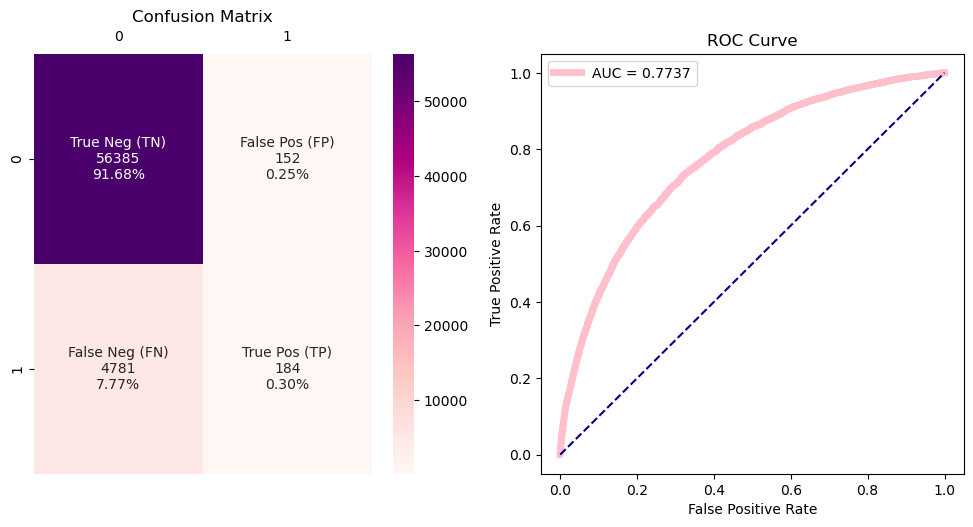

True negative =  56385
False positive =  152
False negative =  4781
True positive =  184


,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Logistic Regression,None,0.77368,0.919791,0.547619,0.037059,0.069421,0.569054,7170.025053


NameError: name 'resultats_eval' is not defined

In [22]:
resultats_eval = pd.DataFrame()

methods_imb = ["None", 'class_weight', 'SMOTE']

for method_imb in methods_imb:
    resultats_model = evaluation_model_without_GS('Logistic Regression', X_train, y_train, X_test, y_test,
                                                  skfold, random_state, scoring, method_imb)
    
    display(resultats_model)
    
    resultats_eval1 = pd.concat([resultats_eval1, resultats_model], ignore_index=True)
    
display(resultats_eval1)

- - - - - Modélisation par Logistic Regression


- - - - - Modélisation par Logistic Regression with class_weight


Entraînement et prédictions du modèle.



C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................................... total time=13.2min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 13.2min remaining:    0.0s
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................................... total time=13.4min


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................................... total time=14.0min


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................................... total time=13.5min


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................................... total time=13.1min
cross_val_score : [0.70470092 0.74114704 0.73438425 0.73131868 0.75335542]




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 67.2min finished


Les métriques d'évaluation : 
 
Le score AUC pour Logistic Regression avec class_weight : 0.7397582287146092.

L'accuracy score de Logistic Regression avec class_weight : 0.7944782283502976.

Le score de précision de Logistic Regression avec class_weight : 0.19800110175493824.

Le score recall de Logistic Regression avec class_weight : 0.5067472306143.

Le score f1 est de Logistic Regression avecc class_weight : 0.28474422815753736.

Le score personnel de métier pour Logistic Regression avec class_weight : 0.6801535855965324.

Rapport sur classification: 
              precision    recall  f1-score   support

         0.0       0.95      0.82      0.88     56537
         1.0       0.20      0.51      0.28      4965

    accuracy                           0.79     61502
   macro avg       0.57      0.66      0.58     61502
weighted avg       0.89      0.79      0.83     61502



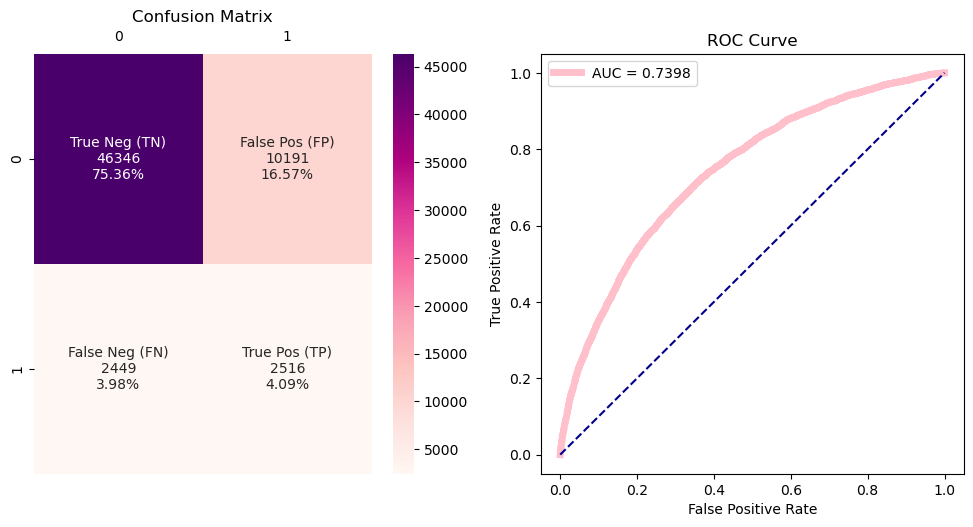

True negative =  46346
False positive =  10191
False negative =  2449
True positive =  2516


,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Logistic Regression,class_weight,0.739758,0.794478,0.198001,0.506747,0.284744,0.680154,5061.26796


- - - - - Modélisation par Logistic Regression


- - - - - Modélisation par Logistic Regression with SMOTE


Entraînement et prédictions du modèle.



C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................................... total time=26.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 26.4min remaining:    0.0s
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................................... total time=24.9min


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................................... total time=29.5min


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................................... total time=30.4min


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................................... total time=24.9min
cross_val_score : [0.76008984 0.75541406 0.76241691 0.75544408 0.76238938]




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 136.0min finished


Les métriques d'évaluation : 
 
Le score AUC pour Logistic Regression avec SMOTE : 0.7588374542700258.

L'accuracy score de Logistic Regression avec SMOTE : 0.7234236284998862.

Le score de précision de Logistic Regression avec SMOTE : 0.17559924589280904.

Le score recall de Logistic Regression avec SMOTE : 0.6565961732124874.

Le score f1 est de Logistic Regression avecc SMOTE : 0.27709307267318317.

Le score personnel de métier pour Logistic Regression avec SMOTE : 0.6968709629477198.

Rapport sur classification: 
              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83     56537
         1.0       0.18      0.66      0.28      4965

    accuracy                           0.72     61502
   macro avg       0.57      0.69      0.55     61502
weighted avg       0.90      0.72      0.78     61502



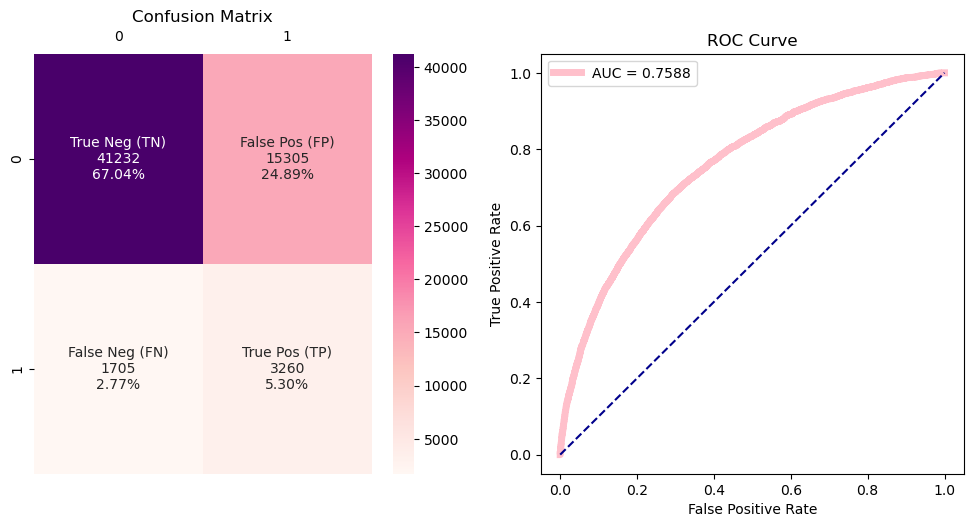

True negative =  41232
False positive =  15305
False negative =  1705
True positive =  3260


,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Logistic Regression,SMOTE,0.758837,0.723424,0.175599,0.656596,0.277093,0.696871,10120.586381


,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Logistic Regression,class_weight,0.739758,0.794478,0.198001,0.506747,0.284744,0.680154,5061.267960
1,Logistic Regression,SMOTE,0.758837,0.723424,0.175599,0.656596,0.277093,0.696871,10120.586381


In [23]:
resultats_eval = pd.DataFrame()
methods_imb = ['class_weight', 'SMOTE']

for method_imb in methods_imb:
    resultats_model = evaluation_model_without_GS('Logistic Regression', X_train, y_train, X_test, y_test,
                                                  skfold, random_state, scoring, method_imb)
    
    display(resultats_model)
    
    resultats_eval = pd.concat([resultats_eval, resultats_model], ignore_index=True)
    
display(resultats_eval)

In [24]:
display(resultats_eval)

,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Logistic Regression,class_weight,0.739758,0.794478,0.198001,0.506747,0.284744,0.680154,5061.267960
1,Logistic Regression,SMOTE,0.758837,0.723424,0.175599,0.656596,0.277093,0.696871,10120.586381


In [26]:
resultats_eval = pd.concat([resultats_eval, resultats_model1], ignore_index=True)
display(resultats_eval)

,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Logistic Regression,class_weight,0.739758,0.794478,0.198001,0.506747,0.284744,0.680154,5061.26796
1,Logistic Regression,SMOTE,0.758837,0.723424,0.175599,0.656596,0.277093,0.696871,10120.586381
2,Logistic Regression,None,0.77368,0.919791,0.547619,0.037059,0.069421,0.569054,7170.025053


In [27]:
# Enregister le data_train_Imp_std
resultats_eval.to_csv('C:\\Users\\LEMuon\\Downloads\\P7_Resultats_Dummy_Logistic.csv', index=False)

In [25]:
resultats_model1 = [{'Modèle': 'Logistic Regression', 'Méthode_imbalance': 'None', 'roc_auc': '0.77368', 
                     'accuracy': '0.919791', 'precision': '0.547619', 'recall': '0.037059', 'f1': '0.069421', 
                     'score_pers': '0.569054', 'Temps': '7170.025053'}]
resultats_model1 = pd.DataFrame(resultats_model1)

display(resultats_model1)

resultats_eval1 = pd.DataFrame({'Modèle' : [],
                                    'Méthode_imbalance' : [],
                                    'roc_auc' : [],
                                    'accuracy' : [],
                                    'precision' : [],
                                    'recall' : [],
                                    'f1' : [],
                                    'score_pers' : [],
                                    'Temps' : []})    

#resultats_eval1 = pd.concat([resultats_eval1, resultats_model1], ignore_index=True)

display(resultats_model1)

,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Logistic Regression,None,0.77368,0.919791,0.547619,0.037059,0.069421,0.569054,7170.025053


,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Logistic Regression,None,0.77368,0.919791,0.547619,0.037059,0.069421,0.569054,7170.025053


### 3.2.2 SelectKBest <a class="anchor" id="section3.2.2"></a>  

On va donc tout d’abord déterminer pour quelles colonnes X on peut le mieux prédire notre Y

On utilise pour ça la f_regression() qui calcule le score de correlation entre chacune de nos features et notre target.

Ensuite avec SelectKBest on choisit les K colonnes les plus corrélées. 

# PCA 0.80

In [10]:
def display_scree_plot(MonPCA):
    """
    Graph representing the eigenvalues of the pca model based on the file
    under study
    pca : pca of the model"""
    scree = MonPCA.explained_variance_ratio_ * 100
    plt.bar(np.arange(len(scree)) + 1, scree)
    plt.plot(np.arange(len(scree)) + 1, scree.cumsum(), c="red", marker="o")
    plt.xlabel("rank of the axis of inertia")
    plt.ylabel("percentage of inertia")
    plt.title("Eboulis des valeurs propres")  
    plt.show(block=False)
    
    return

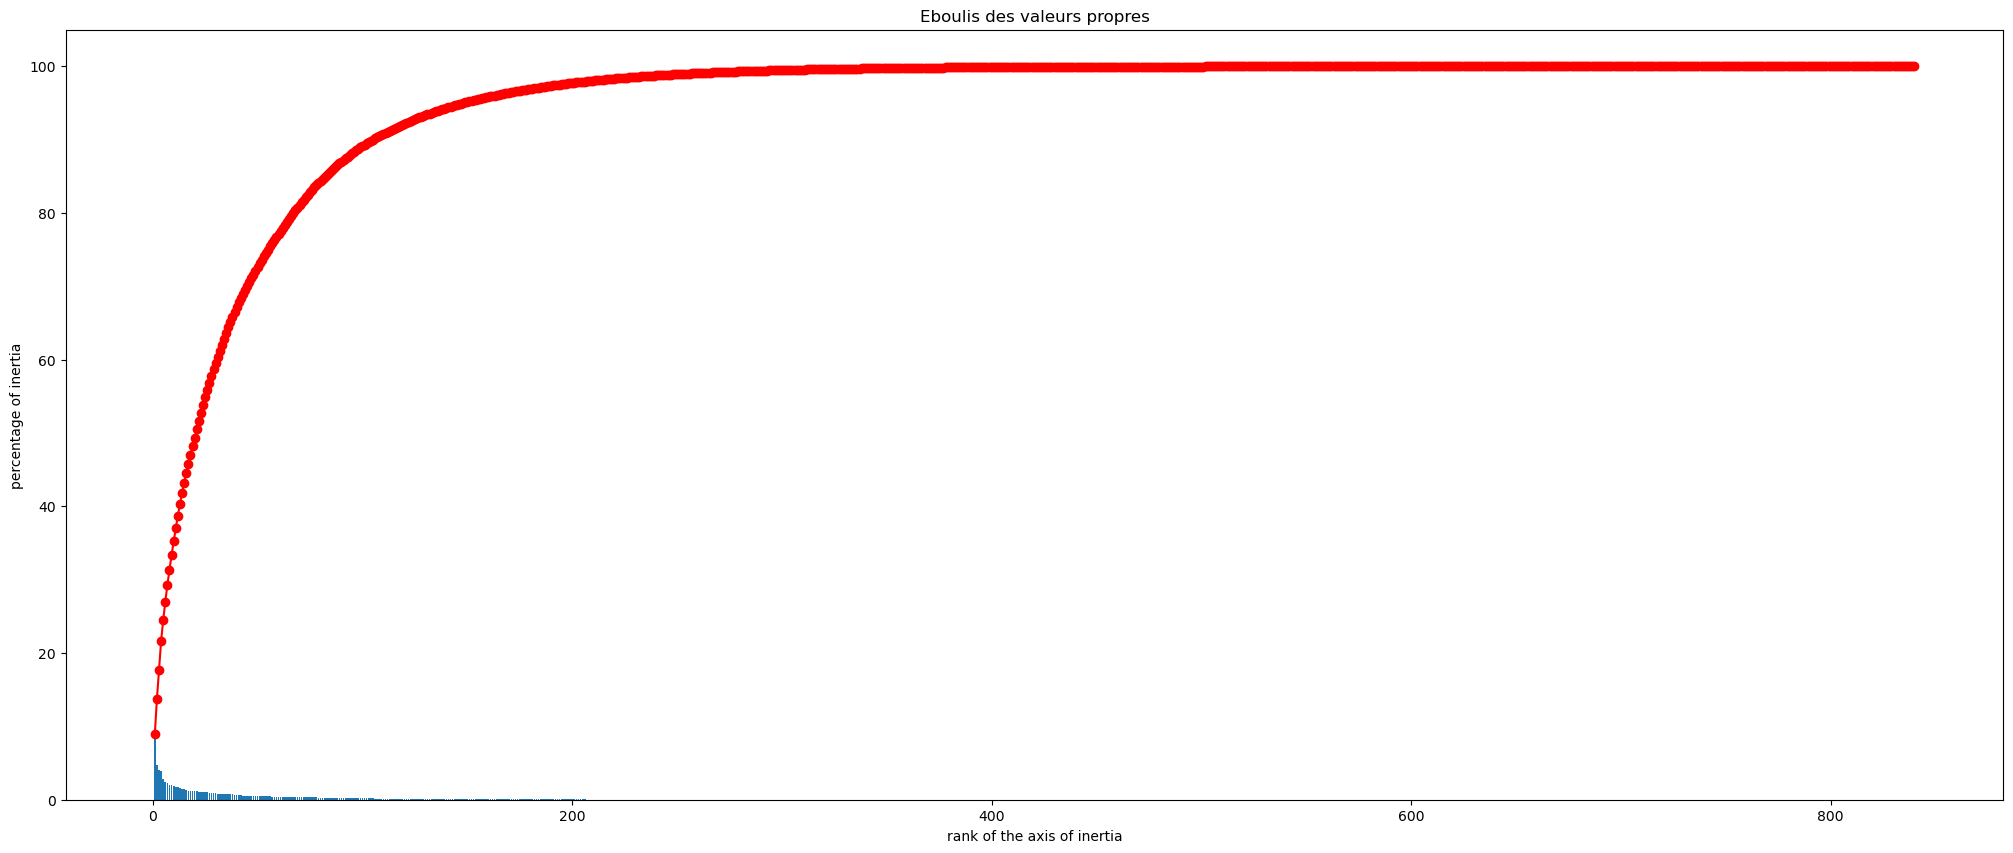

In [11]:
from sklearn.decomposition import PCA, TruncatedSVD

pca = PCA(n_components=data_train.shape[1])

data_PCA = pca.fit_transform(data_train)

plt.figure(figsize=(25, 10))
display_scree_plot(pca)

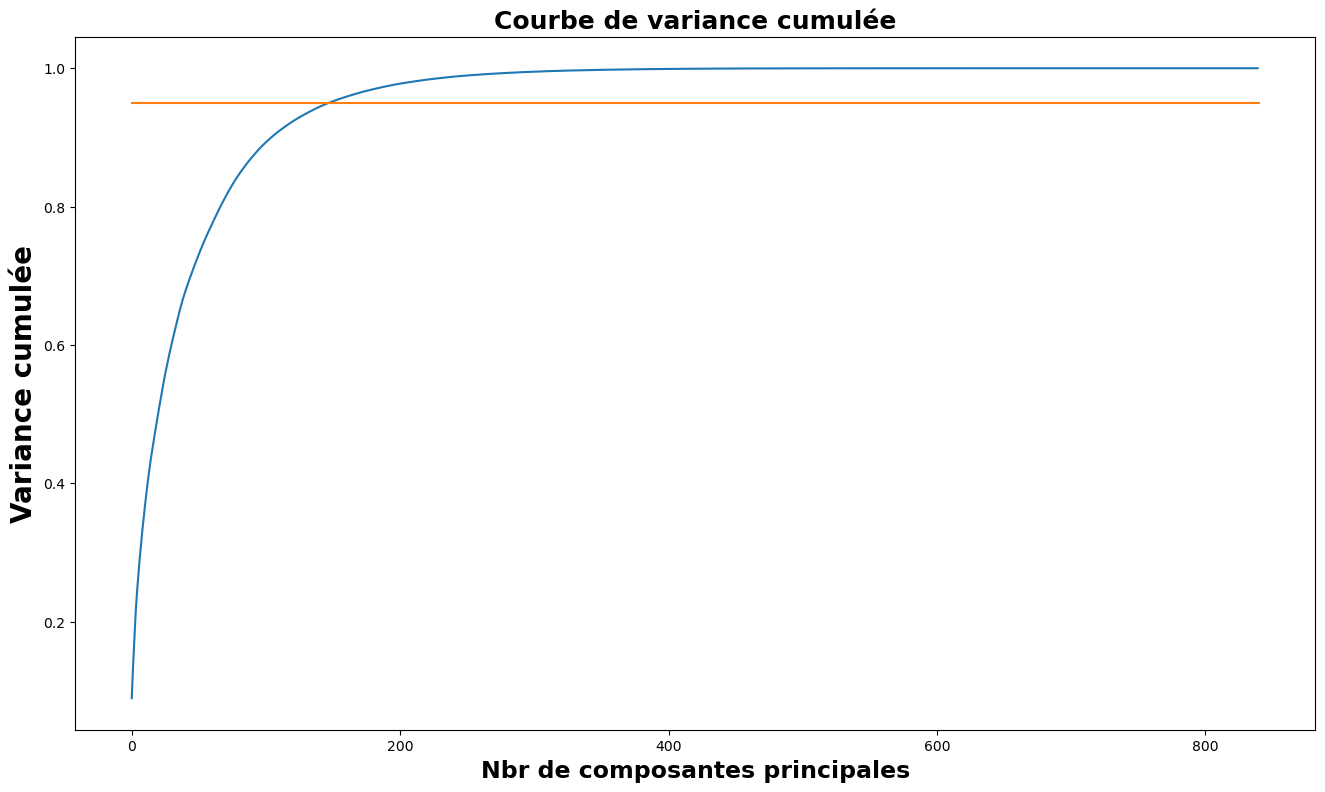

In [15]:
plt.figure(figsize=(16, 9))
plt.ylabel("Variance cumulée", weight='bold', size=20)
plt.xlabel('Nbr de composantes principales', weight='bold', size=17)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title('Courbe de variance cumulée', size=18, weight='bold')
plt.plot([0, data_train.shape[1]], [0.95, 0.95])

In [16]:
c = 0
for i in pca.explained_variance_ratio_.cumsum():
    c += 1
    if(i > 0.95):
        print(
            'Il faut {} composantes pour expliquer 95% de la variance du dataset.'.format(c))
        break

Il faut 148 composantes pour expliquer 95% de la variance du dataset.


Donc on va selectionner 148 variables qui sont le plus corrélées avec la variable `TARGET` par SelectKBest.

In [28]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(f_regression, k=148)
#X_train_kbest = selector.fit_transform(X_train, y_train)
X_kbest = selector.fit_transform(data1, y) 

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


In [29]:
#y = data_train['TARGET']
#data1 = data_train.copy(deep = True)
#data1.drop(['TARGET'], axis = 1, inplace = True)

X_train_kbest, X_test_kbest, y_train, y_test = train_test_split(X_kbest,
                                                                y,
                                                                train_size=0.8, 
                                                                stratify=y,
                                                                random_state=42)

print('train size :', X_train_kbest.shape, y_train.shape)
print('test size :', X_test_kbest.shape, y_test.shape)

train size : (246004, 148) (246004,)
test size : (61502, 148) (61502,)


- - - - - Modélisation par Logistic Regression with SelectKBest


- - - - - Modélisation par Logistic Regression with SelectKBest with None


Entraînement et prédictions du modèle.



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 2.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


[CV] END .................................................... total time= 2.1min
[CV] END .................................................... total time= 2.1min
[CV] END .................................................... total time= 2.1min
[CV] END .................................................... total time= 2.1min
cross_val_score : [0.76246004 0.76179978 0.7651526  0.76571006 0.76267024]




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.5min finished


Les métriques d'évaluation : 
 
Le score AUC pour Logistic Regression with SelectKBest avec None : 0.7620044451813953.

L'accuracy score de Logistic Regression with SelectKBest avec None : 0.9193684758219245.

Le score de précision de Logistic Regression with SelectKBest avec None : 0.5125.

Le score recall de Logistic Regression with SelectKBest avec None : 0.024773413897280966.

Le score f1 est de Logistic Regression with SelectKBest avecc None : 0.04726224783861672.

Le score personnel de métier pour Logistic Regression with SelectKBest avec None : 0.5639175106198463.

Rapport sur classification: 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.51      0.02      0.05      4965

    accuracy                           0.92     61502
   macro avg       0.72      0.51      0.50     61502
weighted avg       0.89      0.92      0.88     61502



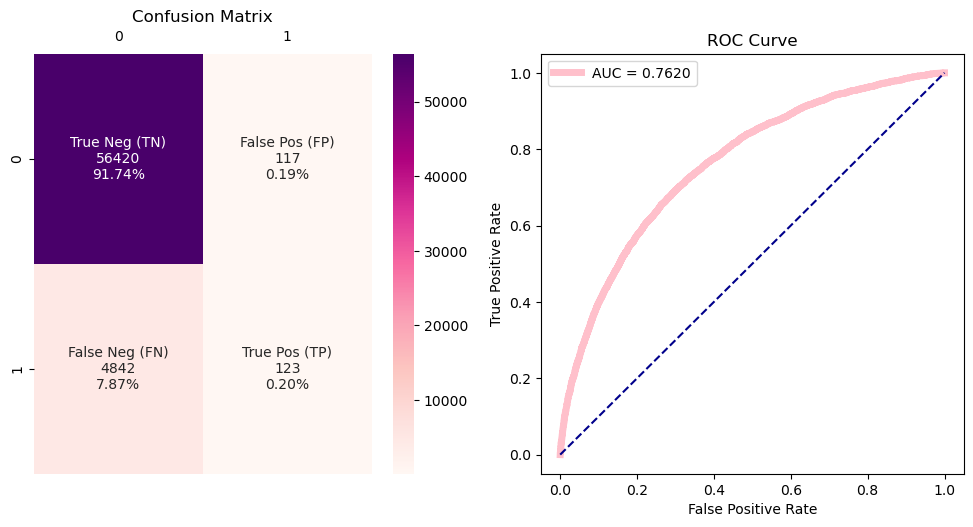

True negative =  56420
False positive =  117
False negative =  4842
True positive =  123


,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Logistic Regression with SelectKBest,None,0.762004,0.919368,0.5125,0.024773,0.047262,0.563918,778.302307


,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Logistic Regression with SelectKBest,None,0.762004,0.919368,0.5125,0.024773,0.047262,0.563918,778.302307


- - - - - Modélisation par Logistic Regression with SelectKBest


- - - - - Modélisation par Logistic Regression with SelectKBest with class_weight


Entraînement et prédictions du modèle.



C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min remaining:    0.0s


[CV] END .................................................... total time= 2.8min


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................................... total time= 2.8min


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................................... total time= 2.9min


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................................... total time= 2.9min


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 14.3min finished


[CV] END .................................................... total time= 2.9min
cross_val_score : [0.69939982 0.7368487  0.74662032 0.73467706 0.75635636]


Les métriques d'évaluation : 
 
Le score AUC pour Logistic Regression with SelectKBest avec class_weight : 0.7374958205857971.

L'accuracy score de Logistic Regression with SelectKBest avec class_weight : 0.9024096777340574.

Le score de précision de Logistic Regression with SelectKBest avec class_weight : 0.3144901610017889.

Le score recall de Logistic Regression with SelectKBest avec class_weight : 0.1770392749244713.

Le score f1 est de Logistic Regression with SelectKBest avecc class_weight : 0.22654639175257732.

Le score personnel de métier pour Logistic Regression with SelectKBest avec class_weight : 0.614197031832591.

Rapport sur classification: 
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95     56537
         1.0       0.31      0.18      0.23      4965

    accuracy 

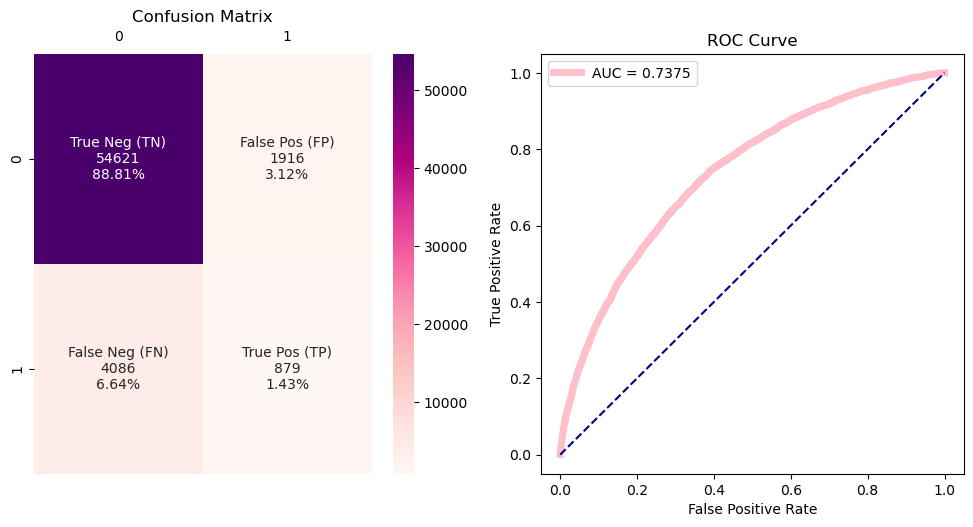

True negative =  54621
False positive =  1916
False negative =  4086
True positive =  879


,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Logistic Regression with SelectKBest,class_weight,0.737496,0.90241,0.31449,0.177039,0.226546,0.614197,1075.013365


,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Logistic Regression with SelectKBest,None,0.762004,0.919368,0.51250,0.024773,0.047262,0.563918,778.302307
1,Logistic Regression with SelectKBest,class_weight,0.737496,0.902410,0.31449,0.177039,0.226546,0.614197,1075.013365


- - - - - Modélisation par Logistic Regression with SelectKBest


- - - - - Modélisation par Logistic Regression with SelectKBest with SMOTE


Entraînement et prédictions du modèle.



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 3.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s


[CV] END .................................................... total time= 3.2min
[CV] END .................................................... total time= 3.0min
[CV] END .................................................... total time= 2.8min
[CV] END .................................................... total time= 3.1min
cross_val_score : [0.75653969 0.7525044  0.76001899 0.75578469 0.75768521]




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 15.5min finished


Les métriques d'évaluation : 
 
Le score AUC pour Logistic Regression with SelectKBest avec SMOTE : 0.7537596292180289.

L'accuracy score de Logistic Regression with SelectKBest avec SMOTE : 0.7006764007674547.

Le score de précision de Logistic Regression with SelectKBest avec SMOTE : 0.1665343784105566.

Le score recall de Logistic Regression with SelectKBest avec SMOTE : 0.6761329305135951.

Le score f1 est de Logistic Regression with SelectKBest avecc SMOTE : 0.267245153843092.

Le score personnel de métier pour Logistic Regression with SelectKBest avec SMOTE : 0.6909245023248521.

Rapport sur classification: 
              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56537
         1.0       0.17      0.68      0.27      4965

    accuracy                           0.70     61502
   macro avg       0.56      0.69      0.54     61502
weighted avg       0.90      0.70      0.77     61502



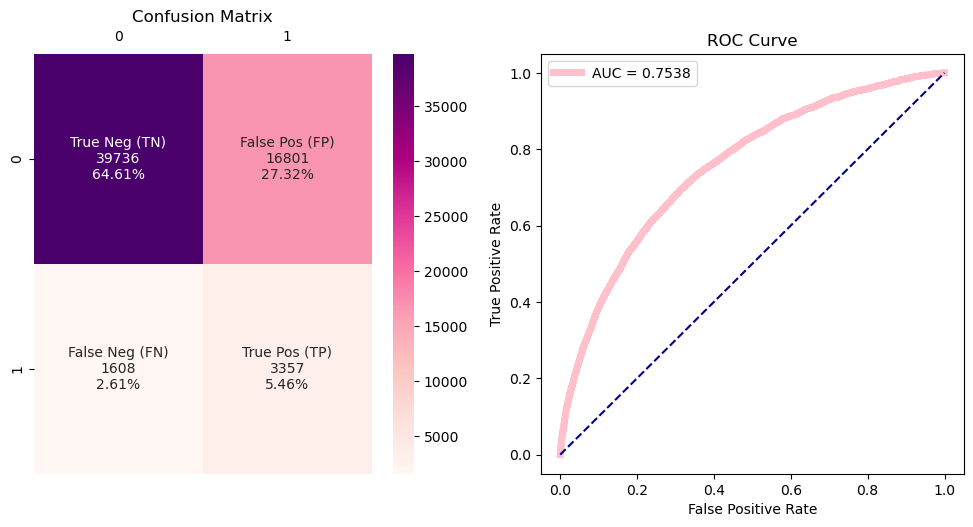

True negative =  39736
False positive =  16801
False negative =  1608
True positive =  3357


,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Logistic Regression with SelectKBest,SMOTE,0.75376,0.700676,0.166534,0.676133,0.267245,0.690925,1178.238325


,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Logistic Regression with SelectKBest,None,0.762004,0.919368,0.512500,0.024773,0.047262,0.563918,778.302307
1,Logistic Regression with SelectKBest,class_weight,0.737496,0.902410,0.314490,0.177039,0.226546,0.614197,1075.013365
2,Logistic Regression with SelectKBest,SMOTE,0.753760,0.700676,0.166534,0.676133,0.267245,0.690925,1178.238325


,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Logistic Regression with SelectKBest,None,0.762004,0.919368,0.512500,0.024773,0.047262,0.563918,778.302307
1,Logistic Regression with SelectKBest,class_weight,0.737496,0.902410,0.314490,0.177039,0.226546,0.614197,1075.013365
2,Logistic Regression with SelectKBest,SMOTE,0.753760,0.700676,0.166534,0.676133,0.267245,0.690925,1178.238325


In [30]:
resultats_eval3 = pd.DataFrame()

methods_imb = ["None", 'class_weight', 'SMOTE']

for method_imb in methods_imb:
    resultats_model = evaluation_model_without_GS('Logistic Regression with SelectKBest', 
                                                  X_train_kbest, y_train, X_test_kbest, y_test,
                                                  skfold, random_state, scoring, method_imb)
    display(resultats_model)
    
    resultats_eval3 = pd.concat([resultats_eval3, resultats_model], ignore_index=True)
    display(resultats_eval3)
    
display(resultats_eval3)

In [31]:
resultats_eval = pd.concat([resultats_eval, resultats_eval3], ignore_index=True)

display(resultats_eval)

,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Logistic Regression,class_weight,0.739758,0.794478,0.198001,0.506747,0.284744,0.680154,5061.26796
1,Logistic Regression,SMOTE,0.758837,0.723424,0.175599,0.656596,0.277093,0.696871,10120.586381
2,Logistic Regression,None,0.77368,0.919791,0.547619,0.037059,0.069421,0.569054,7170.025053
3,Logistic Regression with SelectKBest,None,0.762004,0.919368,0.5125,0.024773,0.047262,0.563918,778.302307
4,Logistic Regression with SelectKBest,class_weight,0.737496,0.90241,0.31449,0.177039,0.226546,0.614197,1075.013365
5,Logistic Regression with SelectKBest,SMOTE,0.75376,0.700676,0.166534,0.676133,0.267245,0.690925,1178.238325


In [32]:
# Enregister le data_train_Imp_std
resultats_eval.to_csv('C:\\Users\\LEMuon\\Downloads\\P7_Resultats_Dummy_Logistic_withKBest.csv', index=False)

### 3.2.3 Avec GridSearch <a class="anchor" id="section3.2.3"></a>  

In [11]:
import sklearn
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,\
                            confusion_matrix, roc_curve, roc_auc_score, RocCurveDisplay, average_precision_score,\
                            ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay

from termcolor import colored

# Fonction pour modelisation simple baseline
def evaluation_model_with_GridSearch(model, model_name, X_train, y_train, X_test, y_test,
                                     param_grid, cv, random_state, scoring, # Validation croisée
                                     ) : #threshold='ROC') : #, class_weight_flag):
    
    print("- - - - - Modélisation par " + model_name )
    
    t0 = time.time()
    #param_grid = {'C' : [0.1, 1, 10, 100]}                   
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               scoring='roc_auc',
                               cv=cv,
                               n_jobs=-1)
    
    # Entraînement et prédiction du modèle sur le dataset train
    grid_search.fit(X_train, y_train)
    cv_score = grid_search.best_score_
    test_score = grid_search.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('\n')
    
    print(f"Entraînement et prédictions du modèle {model_name}.")
    
    # Prédictions sur les données test
    y_pred = grid_search.predict(X_test)    
    ###############
    y_proba = grid_search.predict_proba(X_test)[:, 1]
        
    # Calcul des métriques d'évaluation :
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    ###############
    
    # Temps d'exécuton
    temps = time.time() - t0
    
    # Hyper-paramètres optimisés
    best_params = grid_search.best_params_
    
    # Matrice de confusion
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    
    # Métrique personnelle de métier    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
    score_pers1 = score_pers(tn, fp, fn, tp, coeff_tn, coeff_fp, coeff_fn, coeff_tp)
    
    print(colored("Les métriques d'évaluation : \n ", 'red'))
    
    print(colored('Le score AUC pour {} : {}.\n'.format(model_name, roc_auc), 'blue'))

    print(colored('L\'accuracy score de {} : {}.\n'.format(model_name, accuracy), 'blue'))

    print(colored('Le score de précision de {} : {}.\n'.format(model_name, precision), 'blue'))

    print(colored('Le score recall de {} : {}.\n'.format(model_name, recall), 'blue'))

    print(colored('Le score f1 est de {} : {}.\n'.format(model_name, f1), 'blue'))
        
    print(colored('Le score personnel de métier de {} : {}.\n'.format(model_name, score_pers1), 'blue'))
          
    resultats_model = pd.DataFrame({'Modèle' : [model_name],
                                    'roc_auc' : [roc_auc],
                                    'accuracy' : [accuracy],
                                    'precision' : [precision],
                                    'recall' : [recall],
                                    'f1' : [f1],
                                    'score_pers' : [score_pers1],
                                    'Temps' : [temps],
                                    'best_params' : [best_params]})    
    
    # Rapport de classification
    classif_report = metrics.classification_report(y_test, y_pred)
    print("Rapport sur classification: ", classif_report, sep="\n")
    
     # Affichage du matrice de confusion et la courbe ROC     
    size = (12,12)
    fig = plt.figure(figsize=size)
  
    #plt.subplot(221)
    ax1 = fig.add_subplot(221)
    ax1.title.set_text('Confusion Matrix')
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
    group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='RdPu')
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)


    #plt.subplot(222)
    ax2 = fig.add_subplot(222)
    ax2.title.set_text('ROC Curve')
    fpr,tpr,_ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, color='pink', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    plt.show()
 
    print('True negative = ', tn)
    print('False positive = ', fp)
    print('False negative = ', fn)
    print('True positive = ', tp)
    
    del t0
          
    return resultats_model, grid_search 


In [35]:
model = LogisticRegression(max_iter=500, solver='sag')
display(model.get_params())

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'sag',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

- - - - - Modélisation par Logistic Regression with GS


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py", line 1514, in fit
    accept_large_sparse=solver not in ["liblinear", "sag", "saga"],
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\base.py", line 581, in _validate_data
    X, y

Cross-validation score: nan
Test score: 0.7737508046891944


Entraînement et prédictions du modèle Logistic Regression with GS.
Les métriques d'évaluation : 
 
Le score AUC pour Logistic Regression with GS : 0.7737508046891944.

L'accuracy score de Logistic Regression with GS : 0.9197587070339176.

Le score de précision de Logistic Regression with GS : 0.5441176470588235.

Le score recall de Logistic Regression with GS : 0.03726082578046324.

Le score f1 est de Logistic Regression with GS : 0.06974552309142319.

Le score personnel de métier de Logistic Regression with GS : 0.569114335036755.

Rapport sur classification: 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.54      0.04      0.07      4965

    accuracy                           0.92     61502
   macro avg       0.73      0.52      0.51     61502
weighted avg       0.89      0.92      0.89     61502



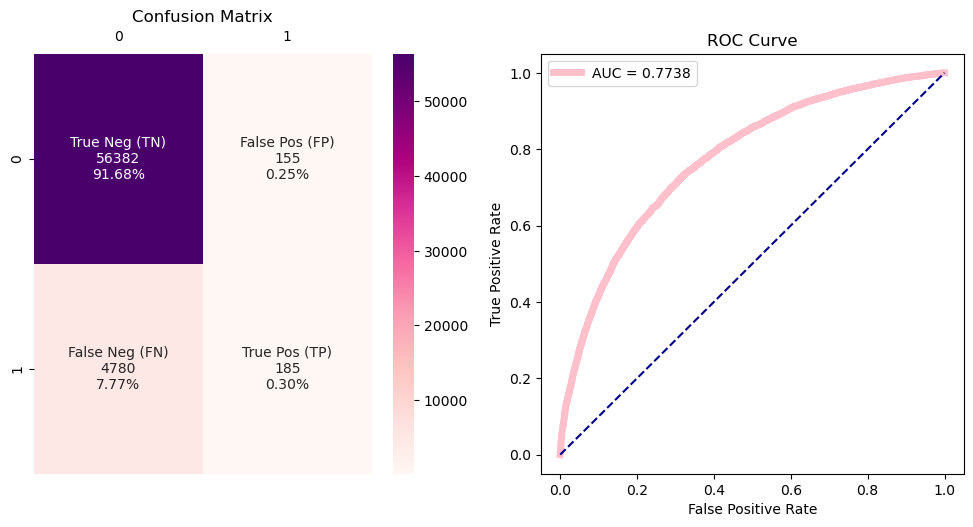

True negative =  56382
False positive =  155
False negative =  4780
True positive =  185


In [36]:
param_grid = {'C' : [20, 10, 1.0, 0.1]}

resultats_model9, best_model =  evaluation_model_with_GridSearch(model, 'Logistic Regression with GS', 
                                                                 X_train, y_train, X_test, y_test,
                                                                 param_grid, skfold, random_state, scoring)

In [38]:
display(resultats_model9)

,Modèle,roc_auc,accuracy,precision,recall,f1,score_pers,Temps,best_params
0,Logistic Regression with GS,0.773751,0.919759,0.544118,0.037261,0.069746,0.569114,2227.216408,{'C': 20}


In [39]:
best_model.best_params_

{'C': 20}

In [37]:
#resultats_eval = pd.read_csv('C:\\Users\\LEMuon\\Downloads\\P7_Resultats_Dummy_Logistic_withKBest.csv')
resultats_eval['best_params'] = np.NaN
display(resultats_eval)

,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps,best_params
0,Logistic Regression,class_weight,0.739758,0.794478,0.198001,0.506747,0.284744,0.680154,5061.26796,NaN
1,Logistic Regression,SMOTE,0.758837,0.723424,0.175599,0.656596,0.277093,0.696871,10120.586381,NaN
2,Logistic Regression,None,0.77368,0.919791,0.547619,0.037059,0.069421,0.569054,7170.025053,NaN
3,Logistic Regression with SelectKBest,None,0.762004,0.919368,0.5125,0.024773,0.047262,0.563918,778.302307,NaN
4,Logistic Regression with SelectKBest,class_weight,0.737496,0.90241,0.31449,0.177039,0.226546,0.614197,1075.013365,NaN
5,Logistic Regression with SelectKBest,SMOTE,0.75376,0.700676,0.166534,0.676133,0.267245,0.690925,1178.238325,NaN


In [40]:
resultats_eval = pd.concat([resultats_eval, resultats_model9], ignore_index=True)
display(resultats_eval)

,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps,best_params
0,Logistic Regression,class_weight,0.739758,0.794478,0.198001,0.506747,0.284744,0.680154,5061.26796,NaN
1,Logistic Regression,SMOTE,0.758837,0.723424,0.175599,0.656596,0.277093,0.696871,10120.586381,NaN
2,Logistic Regression,None,0.77368,0.919791,0.547619,0.037059,0.069421,0.569054,7170.025053,NaN
3,Logistic Regression with SelectKBest,None,0.762004,0.919368,0.5125,0.024773,0.047262,0.563918,778.302307,NaN
4,Logistic Regression with SelectKBest,class_weight,0.737496,0.90241,0.31449,0.177039,0.226546,0.614197,1075.013365,NaN
5,Logistic Regression with SelectKBest,SMOTE,0.75376,0.700676,0.166534,0.676133,0.267245,0.690925,1178.238325,NaN
6,Logistic Regression with GS,NaN,0.773751,0.919759,0.544118,0.037261,0.069746,0.569114,2227.216408,{'C': 20}


- - - - - Modélisation par Logistic Regression with GS


C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py", line 1514, in fit
    accept_large_sparse=solver not in ["liblinear", "sag", "saga"],
  File "C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\base.py", line 581, in _validate_data
    X, y

Cross-validation score: nan
Test score: 0.7417181675766661


Entraînement et prédictions du modèle Logistic Regression with GS.
Les métriques d'évaluation : 
 
Le score AUC pour Logistic Regression with GS : 0.7417181675766661.

L'accuracy score de Logistic Regression with GS : 0.7826899938213392.

Le score de précision de Logistic Regression with GS : 0.19311705392371767.

Le score recall de Logistic Regression with GS : 0.5323262839879154.

Le score f1 est de Logistic Regression with GS : 0.28341643879684736.

Le score personnel de métier de Logistic Regression with GS : 0.6832125586112622.

Rapport sur classification: 
              precision    recall  f1-score   support

         0.0       0.95      0.80      0.87     56537
         1.0       0.19      0.53      0.28      4965

    accuracy                           0.78     61502
   macro avg       0.57      0.67      0.58     61502
weighted avg       0.89      0.78      0.82     61502



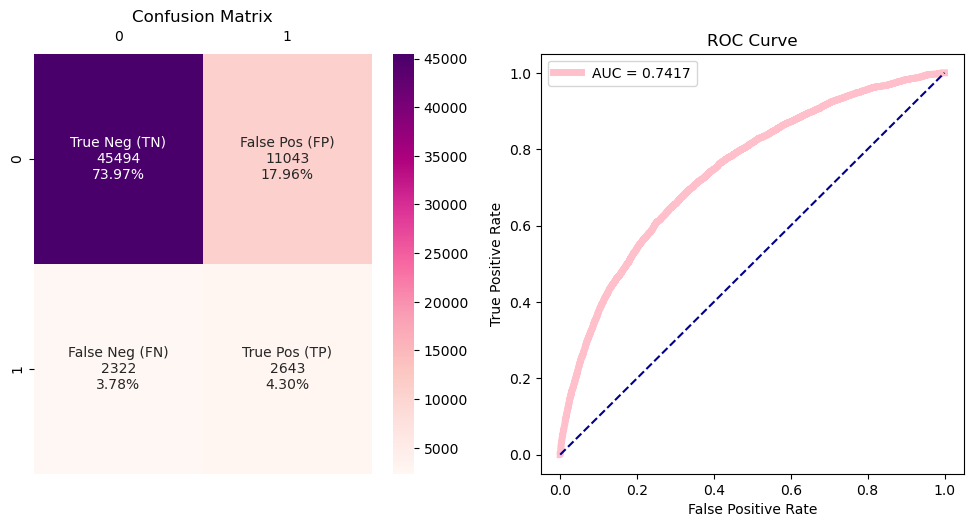

True negative =  45494
False positive =  11043
False negative =  2322
True positive =  2643


In [42]:
model = LogisticRegression(max_iter=500, solver='sag', class_weight='balanced')
param_grid = {'C' : [20, 10, 1.0, 0.1]}

resultats_model8, best_model =  evaluation_model_with_GridSearch(model, 'Logistic Regression with GS', 
                                                                 X_train, y_train, X_test, y_test,
                                                                 param_grid, skfold, random_state, scoring)

In [43]:
display(resultats_model8)

,Modèle,roc_auc,accuracy,precision,recall,f1,score_pers,Temps,best_params
0,Logistic Regression with GS,0.741718,0.78269,0.193117,0.532326,0.283416,0.683213,2827.025472,{'C': 20}


In [46]:
resultats_eval = pd.concat([resultats_eval, resultats_model8], ignore_index=True)

In [45]:
resultats_eval['Méthode_imbalance'][7] = 'class_weight'
display(resultats_eval)

,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps,best_params
0,Logistic Regression,class_weight,0.739758,0.794478,0.198001,0.506747,0.284744,0.680154,5061.26796,NaN
1,Logistic Regression,SMOTE,0.758837,0.723424,0.175599,0.656596,0.277093,0.696871,10120.586381,NaN
2,Logistic Regression,None,0.77368,0.919791,0.547619,0.037059,0.069421,0.569054,7170.025053,NaN
3,Logistic Regression with SelectKBest,None,0.762004,0.919368,0.5125,0.024773,0.047262,0.563918,778.302307,NaN
4,Logistic Regression with SelectKBest,class_weight,0.737496,0.90241,0.31449,0.177039,0.226546,0.614197,1075.013365,NaN
5,Logistic Regression with SelectKBest,SMOTE,0.75376,0.700676,0.166534,0.676133,0.267245,0.690925,1178.238325,NaN
6,Logistic Regression with GS,NaN,0.773751,0.919759,0.544118,0.037261,0.069746,0.569114,2227.216408,{'C': 20}
7,Logistic Regression with GS,class_weight,0.741718,0.78269,0.193117,0.532326,0.283416,0.683213,2827.025472,{'C': 20}


In [47]:
#Enregistrement le data de résultats d'évaluation
resultats_eval.to_csv('C:\\Users\\LEMuon\\Downloads\\P7_Resultats_Dummy_Logistic_withKBest_GS.csv', index=False)

# Importance des variables

In [22]:
model = LogisticRegression(max_iter=500, solver='sag', C=20, class_weight='balanced')
model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


LogisticRegression(C=20, class_weight='balanced', max_iter=500, solver='sag')

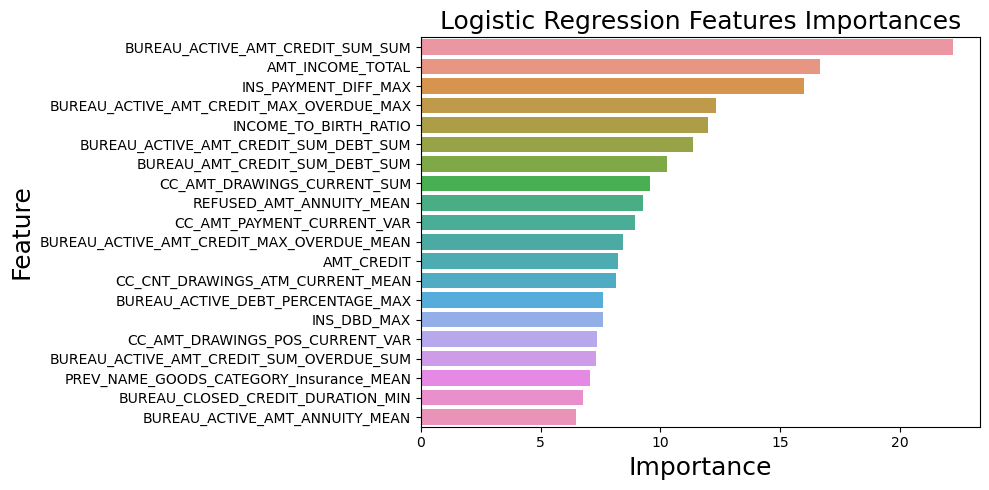

In [23]:
importance=model.coef_[0]
importance_dt = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)[0:20]

df_feature_importances = pd.DataFrame({'feature':importance_dt.index, 'importance':importance_dt.values})     

# Visualisation
plt.figure(figsize=(10, 5))
sns.barplot(x="importance", y="feature", data=df_feature_importances)
plt.title('Logistic Regression Features Importances', fontsize=18)
plt.xlabel('Importance', fontsize=18)
plt.ylabel('Feature', fontsize=18)
plt.tight_layout()

## 3.3 Random Forest et Light GBM <a class="anchor" id="section3.3"></a> 


### 3.3.1 Sans GridSearch <a class="anchor" id="section3.3.1"></a> 

In [18]:
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from collections import Counter

# Fonction pour les modèles Random Forest et Light GBM
def eval_model_without_GS(model_name, X_train, y_train, X_test, y_test,
                          cv, random_state, scoring, # Validation croisée
                          method_imb) : #threshold='ROC') : #, class_weight_flag):
    
    print("- - - - - Modélisation par " + model_name )
    print("\n")
    t0 = time.time()
    
    # Modèle    
    if model_name == 'Random Forest' :
        if method_imb == 'class_weight' :
            model = RandomForestClassifier(random_state=random_state, n_jobs=-1, class_weight = 'balanced')
        if method_imb == 'None' :       
            model = RandomForestClassifier(random_state=random_state, n_jobs=-1) 
        if method_imb == 'SMOTE' :
            model = imbpipeline(steps = [['smote', SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=random_state, n_jobs=-1)],
                                         ['classifier', RandomForestClassifier(random_state=random_state, n_jobs=-1)]])
    
    else :
        if method_imb == 'class_weight' :
            model = LGBMClassifier(random_state=random_state, n_jobs=-1, class_weight = 'balanced')
        if method_imb == 'None' :
            model = LGBMClassifier(random_state=random_state, n_jobs=-1)
        if method_imb == 'SMOTE' :
            model = imbpipeline(steps = [['smote', SMOTE(random_state=random_state)],
                                         ['classifier', LGBMClassifier(random_state=random_state, n_jobs=-1)]])
        
    print("- - - - - Modélisation par " + model_name + " and " + method_imb)
    print("\n")
    
    print("Entraînement et prédictions du modèle.\n")
    model.fit(X_train, y_train)
    
    print("cross_val_score :", cross_val_score(model, X=X_train, y=y_train, 
                                             cv=cv, scoring="roc_auc", verbose=2))
    
    #Temps d'exécution
    temps = time.time() - t0

    # Prédictions sur les données test
    y_pred = model.predict(X_test)
    
    ###############
    y_proba = model.predict_proba(X_test)[:, 1]
        
    # Calcul des métriques d'évaluation :
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    ###############
    # Métrique personnelle de métier
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
    score_pers1 = score_pers(tn, fp, fn, tp, coeff_tn, coeff_fp, coeff_fn, coeff_tp)
    
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    
    print(colored("Les métriques d'évaluation : \n ", 'red'))

    print(colored('Le score AUC pour {} avec {} : {}.\n'.format(model_name, method_imb, roc_auc), 'blue'))

    print(colored('L\'accuracy score de {} avec {} : {}.\n'.format(model_name, method_imb, accuracy), 'blue'))

    print(colored('Le score de précision de {} avec {} : {}.\n'.format(model_name, method_imb, precision), 'blue'))

    print(colored('Le score recall de {} avec {} : {}.\n'.format(model_name, method_imb, recall), 'blue'))

    print(colored('Le score f1 est de {} avecc {} : {}.\n'.format(model_name, method_imb, f1), 'blue'))   
    
    print(colored('Le score personnel de métier pour {} avec {} : {}.\n'.format(model_name, method_imb, score_pers1), 'blue'))
    
    #pr_auc = average_precision_score(y_test, y_proba[:,1])
           
    resultats_modele = pd.DataFrame({'Modèle' : [model_name],
                                     'Méthode_imbalance' : [method_imb],
                                     'roc_auc' : [roc_auc],
                                     'accuracy' : [accuracy],
                                     'precision' : [precision],
                                     'recall' : [recall],
                                     'f1' : [f1],
                                     'score_pers' : [score_pers1],
                                     'Temps' : [temps]})    
    
    # Rapport de classification
    classif_report = metrics.classification_report(y_test, y_pred)
    print("Rapport sur classification: ", classif_report, sep="\n")
    
     # Affichage du matrice de confusion et la courbe ROC     
    size = (12,12)
    fig = plt.figure(figsize=size)
  
    #Courbe ROC    
    ax1 = fig.add_subplot(221)
    ax1.title.set_text('Confusion Matrix')
    group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='RdPu')
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

    # Matrice de confusion    
    ax2 = fig.add_subplot(222)
    ax2.title.set_text('ROC Curve')
    fpr,tpr,_ = roc_curve(y_test, y_proba)#[:,1])    #pour la courbe ROC utilisation de la probabiilité d'être 1
    plt.plot(fpr, tpr, color='pink', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    plt.show()
 
    print('True negative = ', tn)
    print('False positive = ', fp)
    print('False negative = ', fn)
    print('True positive = ', tp)

    del t0
    
    return resultats_modele # conf_matrix, classif_report 


- - - - - Modélisation par Random Forest


- - - - - Modélisation par Random Forest and None


Entraînement et prédictions du modèle.



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 2.8min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min remaining:    0.0s


[CV] END .................................................... total time= 3.0min
[CV] END .................................................... total time= 2.6min
[CV] END .................................................... total time= 2.7min
[CV] END .................................................... total time= 2.9min
cross_val_score : [0.73092659 0.73400024 0.7253443  0.73407985 0.72640158]


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.9min finished


Les métriques d'évaluation : 
 
Le score AUC pour Random Forest avec None : 0.7327416577770341.

L'accuracy score de Random Forest avec None : 0.9194172547234236.

Le score de précision de Random Forest avec None : 0.6363636363636364.

Le score recall de Random Forest avec None : 0.004229607250755287.

Le score f1 est de Random Forest avecc None : 0.008403361344537815.

Le score personnel de métier pour Random Forest avec None : 0.5557842027643447.

Rapport sur classification: 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.64      0.00      0.01      4965

    accuracy                           0.92     61502
   macro avg       0.78      0.50      0.48     61502
weighted avg       0.90      0.92      0.88     61502



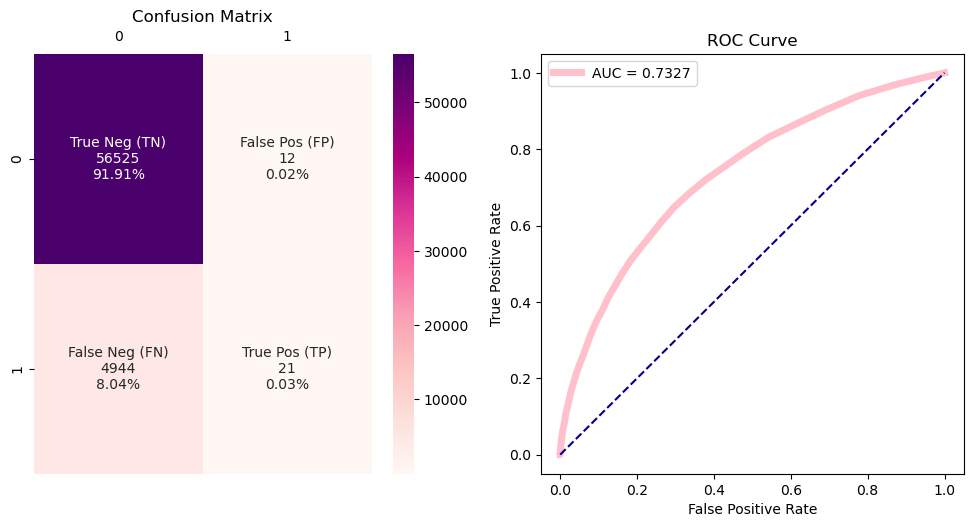

True negative =  56525
False positive =  12
False negative =  4944
True positive =  21


,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Random Forest,None,0.732742,0.919417,0.636364,0.00423,0.008403,0.555784,1036.270463


- - - - - Modélisation par Random Forest


- - - - - Modélisation par Random Forest and class_weight


Entraînement et prédictions du modèle.



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 1.8min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV] END .................................................... total time= 1.7min
[CV] END .................................................... total time= 1.8min
[CV] END .................................................... total time= 1.9min
[CV] END .................................................... total time= 1.9min
cross_val_score : [0.74459781 0.73896607 0.74642635 0.74534576 0.74407866]


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.1min finished


Les métriques d'évaluation : 
 
Le score AUC pour Random Forest avec class_weight : 0.742663501150607.

L'accuracy score de Random Forest avec class_weight : 0.9193359565542584.

Le score de précision de Random Forest avec class_weight : 0.5294117647058824.

Le score recall de Random Forest avec class_weight : 0.0072507552870090634.

Le score f1 est de Random Forest avecc class_weight : 0.014305583151202068.

Le score personnel de métier pour Random Forest avec class_weight : 0.5569356047800332.

Rapport sur classification: 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.53      0.01      0.01      4965

    accuracy                           0.92     61502
   macro avg       0.72      0.50      0.49     61502
weighted avg       0.89      0.92      0.88     61502



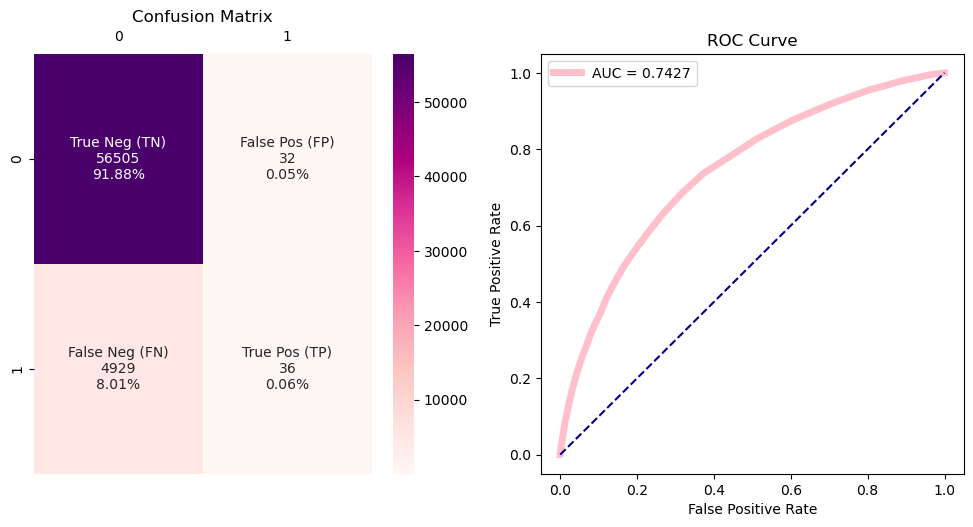

True negative =  56505
False positive =  32
False negative =  4929
True positive =  36


,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Random Forest,class_weight,0.742664,0.919336,0.529412,0.007251,0.014306,0.556936,671.992913


- - - - - Modélisation par Random Forest


- - - - - Modélisation par Random Forest and SMOTE


Entraînement et prédictions du modèle.



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 6.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.3min remaining:    0.0s


[CV] END .................................................... total time= 6.0min
[CV] END .................................................... total time= 5.7min
[CV] END .................................................... total time= 5.7min
[CV] END .................................................... total time= 5.7min
cross_val_score : [0.72631019 0.72952027 0.73258139 0.72935065 0.72441757]


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 29.5min finished


Les métriques d'évaluation : 
 
Le score AUC pour Random Forest avec SMOTE : 0.7255674950256267.

L'accuracy score de Random Forest avec SMOTE : 0.9103281194107509.

Le score de précision de Random Forest avec SMOTE : 0.2968980797636632.

Le score recall de Random Forest avec SMOTE : 0.0809667673716012.

Le score f1 est de Random Forest avecc SMOTE : 0.1272353220446273.

Le score personnel de métier pour Random Forest avec SMOTE : 0.5807965742115346.

Rapport sur classification: 
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95     56537
         1.0       0.30      0.08      0.13      4965

    accuracy                           0.91     61502
   macro avg       0.61      0.53      0.54     61502
weighted avg       0.87      0.91      0.89     61502



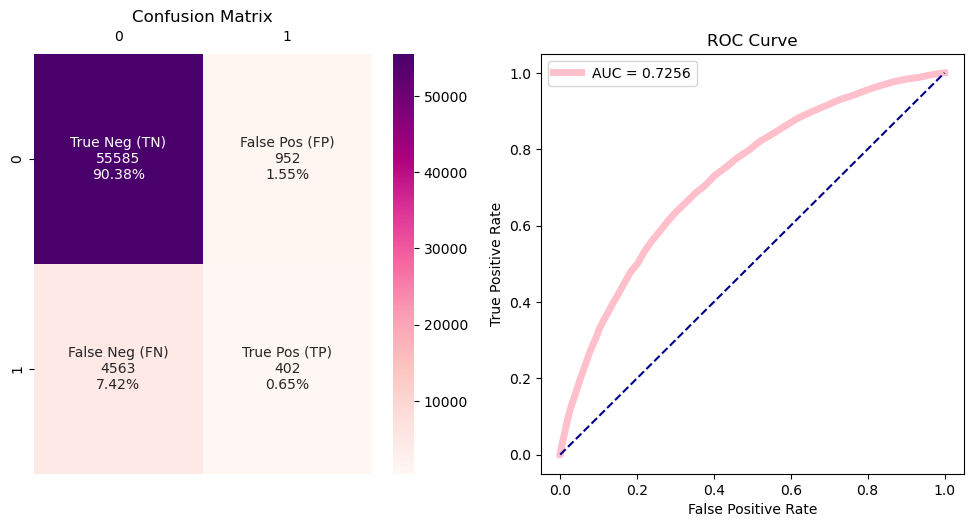

True negative =  55585
False positive =  952
False negative =  4563
True positive =  402


,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Random Forest,SMOTE,0.725567,0.910328,0.296898,0.080967,0.127235,0.580797,2229.525759


- - - - - Modélisation par Light GBM


- - - - - Modélisation par Light GBM and None


Entraînement et prédictions du modèle.



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  44.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   44.6s remaining:    0.0s


[CV] END .................................................... total time=  41.6s
[CV] END .................................................... total time=  41.9s
[CV] END .................................................... total time=  44.2s
[CV] END .................................................... total time=  55.6s
cross_val_score : [0.78512048 0.78258731 0.78320206 0.7840452  0.78274947]


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.8min finished


Les métriques d'évaluation : 
 
Le score AUC pour Light GBM avec None : 0.7804783973336107.

L'accuracy score de Light GBM avec None : 0.9201164189782446.

Le score de précision de Light GBM avec None : 0.5769230769230769.

Le score recall de Light GBM avec None : 0.03927492447129909.

Le score f1 est de Light GBM avecc None : 0.07354327739015652.

Le score personnel de métier pour Light GBM avec None : 0.5701301819215184.

Rapport sur classification: 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.58      0.04      0.07      4965

    accuracy                           0.92     61502
   macro avg       0.75      0.52      0.52     61502
weighted avg       0.89      0.92      0.89     61502



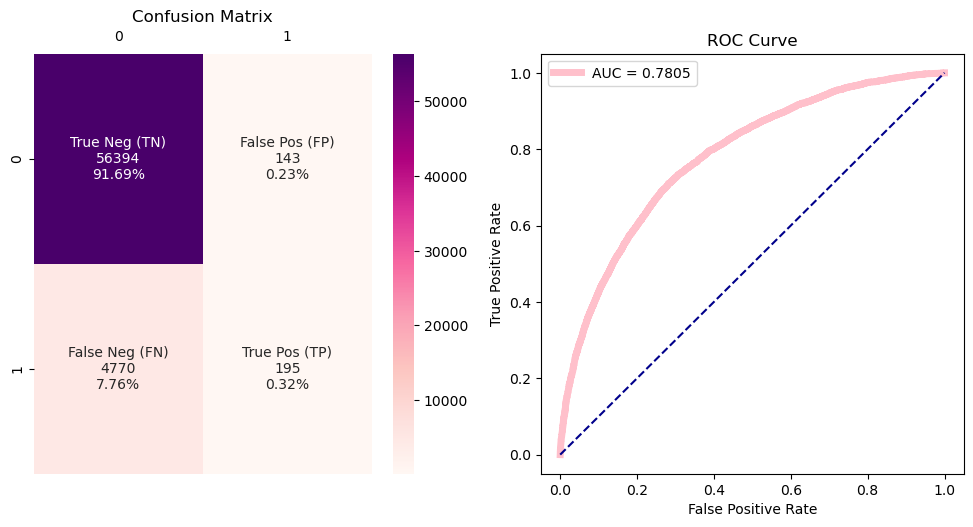

True negative =  56394
False positive =  143
False negative =  4770
True positive =  195


,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Light GBM,None,0.780478,0.920116,0.576923,0.039275,0.073543,0.57013,278.661322


- - - - - Modélisation par Light GBM


- - - - - Modélisation par Light GBM and class_weight


Entraînement et prédictions du modèle.



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  59.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   59.9s remaining:    0.0s


[CV] END .................................................... total time=  58.5s
[CV] END .................................................... total time=  52.0s
[CV] END .................................................... total time=  50.5s
[CV] END .................................................... total time=  45.3s
cross_val_score : [0.78509925 0.78397819 0.78604101 0.78577325 0.78562016]


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.5min finished


Les métriques d'évaluation : 
 
Le score AUC pour Light GBM avec class_weight : 0.7838793018487069.

L'accuracy score de Light GBM avec class_weight : 0.7335208611102078.

Le score de précision de Light GBM avec class_weight : 0.18735632183908046.

Le score recall de Light GBM avec class_weight : 0.6894259818731118.

Le score f1 est de Light GBM avecc class_weight : 0.29464170432537123.

Le score personnel de métier pour Light GBM avec class_weight : 0.7160005683516333.

Rapport sur classification: 
              precision    recall  f1-score   support

         0.0       0.96      0.74      0.84     56537
         1.0       0.19      0.69      0.29      4965

    accuracy                           0.73     61502
   macro avg       0.58      0.71      0.57     61502
weighted avg       0.90      0.73      0.79     61502



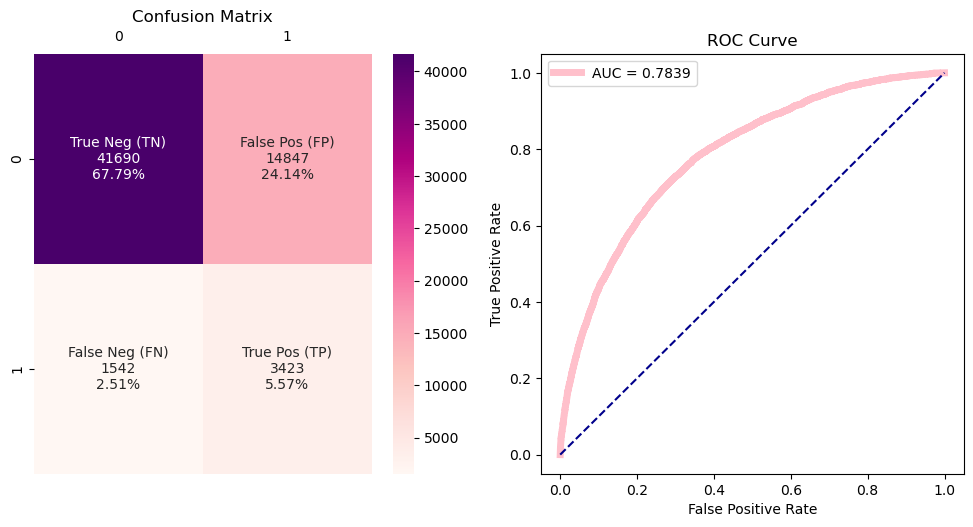

True negative =  41690
False positive =  14847
False negative =  1542
True positive =  3423


,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Light GBM,class_weight,0.783879,0.733521,0.187356,0.689426,0.294642,0.716001,327.581824


- - - - - Modélisation par Light GBM


- - - - - Modélisation par Light GBM and SMOTE


Entraînement et prédictions du modèle.



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 2.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s


[CV] END .................................................... total time= 2.3min
[CV] END .................................................... total time= 2.3min
[CV] END .................................................... total time= 2.6min
[CV] END .................................................... total time= 2.4min
cross_val_score : [0.76242482 0.75948992 0.76660604 0.75972762 0.76237733]


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 11.9min finished


Les métriques d'évaluation : 
 
Le score AUC pour Light GBM avec SMOTE : 0.7562110570373748.

L'accuracy score de Light GBM avec SMOTE : 0.9185392344964391.

Le score de précision de Light GBM avec SMOTE : 0.4503311258278146.

Le score recall de Light GBM avec SMOTE : 0.04108761329305136.

Le score f1 est de Light GBM avecc SMOTE : 0.0753045404208195.

Le score personnel de métier pour Light GBM avec SMOTE : 0.5698999015183808.

Rapport sur classification: 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.45      0.04      0.08      4965

    accuracy                           0.92     61502
   macro avg       0.69      0.52      0.52     61502
weighted avg       0.88      0.92      0.89     61502



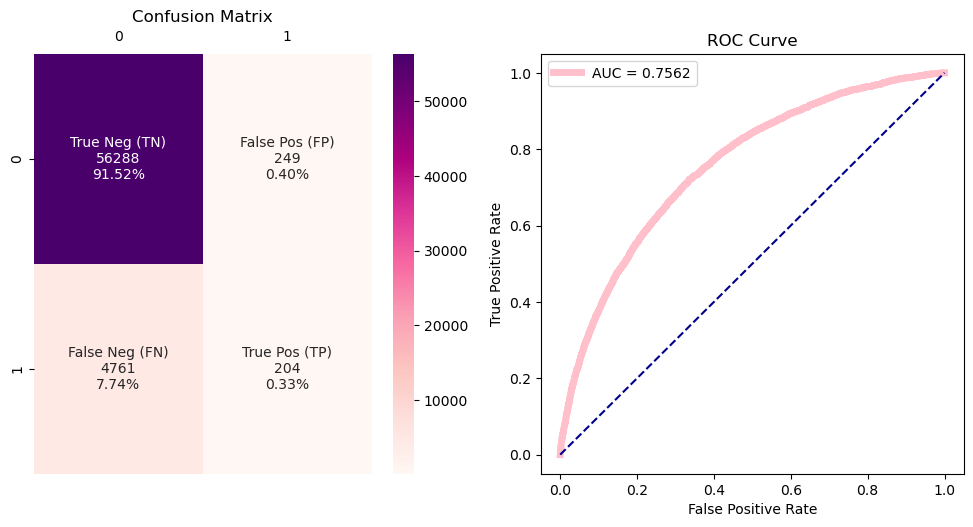

True negative =  56288
False positive =  249
False negative =  4761
True positive =  204


,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Light GBM,SMOTE,0.756211,0.918539,0.450331,0.041088,0.075305,0.5699,1014.495179


,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Random Forest,None,0.732742,0.919417,0.636364,0.004230,0.008403,0.555784,1036.270463
1,Random Forest,class_weight,0.742664,0.919336,0.529412,0.007251,0.014306,0.556936,671.992913
2,Random Forest,SMOTE,0.725567,0.910328,0.296898,0.080967,0.127235,0.580797,2229.525759
3,Light GBM,None,0.780478,0.920116,0.576923,0.039275,0.073543,0.570130,278.661322
4,Light GBM,class_weight,0.783879,0.733521,0.187356,0.689426,0.294642,0.716001,327.581824
5,Light GBM,SMOTE,0.756211,0.918539,0.450331,0.041088,0.075305,0.569900,1014.495179


In [19]:
resultats_eval2 = pd.DataFrame()

methods_imb = ["None", 'class_weight', 'SMOTE']
models = ['Random Forest', 'Light GBM']

for model_name in models:

    for method_imb in methods_imb:
        resultats_model = eval_model_without_GS(model_name, X_train, y_train, X_test, y_test,
                                                skfold, random_state, scoring, # Validation croisée
                                                method_imb)
    
        resultats_eval2 = pd.concat([resultats_eval2, resultats_model], ignore_index=True)

        display(resultats_model)
    
display(resultats_eval2)

In [20]:
display(resultats_eval2)

,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Random Forest,None,0.732742,0.919417,0.636364,0.004230,0.008403,0.555784,1036.270463
1,Random Forest,class_weight,0.742664,0.919336,0.529412,0.007251,0.014306,0.556936,671.992913
2,Random Forest,SMOTE,0.725567,0.910328,0.296898,0.080967,0.127235,0.580797,2229.525759
3,Light GBM,None,0.780478,0.920116,0.576923,0.039275,0.073543,0.570130,278.661322
4,Light GBM,class_weight,0.783879,0.733521,0.187356,0.689426,0.294642,0.716001,327.581824
5,Light GBM,SMOTE,0.756211,0.918539,0.450331,0.041088,0.075305,0.569900,1014.495179


In [21]:
# Enregister le data_train_Imp_std
resultats_eval2.to_csv('C:\\Users\\LEMuon\\Downloads\\P7_Resultats_RF_LGBM.csv', index=False)

Le choix de modèle se porte sur le modèle **Light BGM avec class_weight**.

### 3.3.2 Light GBM avec GridSearch <a class="anchor" id="section3.3.2"></a> 

https://techfor-today.com/lightgbm-using-python-hyperparameter-tuning-of-lightgbm/

On va rechercher les meilleurs hyperparamètres pour le modèle basé sur LightGBM avec une recherche croisée sur grille. Pour éviter le problème de mémoire, on va faire cette recherche avec les données réduites avec SelectKBest. 

https://www.kaggle.com/code/bitit1994/parameter-grid-search-lgbm-with-scikit-learn/notebook

In [11]:
model = LGBMClassifier(random_state=random_state, n_jobs=-1, class_weight = 'balanced')
display(model.get_params())

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [12]:
param_grid = {'learning_rate': [0.005, 0.01],
              'n_estimators': [500], # ne pas changer
              'num_leaves': [31, 50, 100], # large num_leaves helps improve accuracy but might lead to over-fitting                                         
              #'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
              #'objective' : ['binary'],
              #'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
              #'random_state' : [500],
              #'colsample_bytree' : [0.64, 0.65, 0.66], 
              #'subsample' : [0.7,0.75], 
              #'reg_alpha' : [1,1.2],
              #'reg_lambda' : [1,1.2,1.4], 
              'max_depth':[-1, 1, 2]
             }


In [14]:
resultats_model2, best_model =  evaluation_model_with_GridSearch(model, 'Light GBM with class_weight and GS', 
                                                                 X_train, y_train, X_test, y_test,
                                                                 param_grid, skfold, random_state, scoring)

- - - - - Modélisation par Light GBM with class_weight and GS


MemoryError: Unable to allocate 315. MiB for an array with shape (839, 49201) and data type float64

In [80]:
display(resultats_model2)

,Modèle,roc_auc,accuracy,precision,recall,f1,score_pers,Temps,best_params
0,"Light GBM with class_weight, SelectKBest and GS",0.706542,0.732041,0.184157,0.676133,0.289471,0.709952,6182.110392,"{'learning_rate': 0.01, 'max_depth': -1, 'n_es..."


In [81]:
display(best_model.best_params_)


{'learning_rate': 0.01,
 'max_depth': -1,
 'n_estimators': 1400,
 'num_leaves': 31}

In [ ]:
model = LGBMClassifier(random_state=random_state, n_jobs=-1, class_weight = 'balanced', learning_rate= 0.01,
                       max_depth=-1, n_estimators=500, num_leaves=31)

# Best_model par GridSearch

On regarde les métriques du modèle Light BGM avec les paramètres obtenus.

In [14]:
model = LGBMClassifier(random_state=random_state, n_jobs=-1, class_weight = 'balanced',
                       learning_rate=0.01, max_depth=-1, n_estimators=1400, num_leaves=31)

- - - - - Modélisation par Light GBM with best params
Entraînement et prédictions du modèle Light GBM with best params.
Les métriques d'évaluation : 
 
Le score AUC pour Light GBM with best params : 0.7130926407558393.

L'accuracy score de Light GBM with best params : 0.7429026698318754.

Le score de précision de Light GBM with best params : 0.1914082503556188.

Le score recall de Light GBM with best params : 0.6775427995971802.

Le score f1 est de Light GBM with best params : 0.29849157054125997.

Rapport sur classification: 
              precision    recall  f1-score   support

         0.0       0.96      0.75      0.84     56537
         1.0       0.19      0.68      0.30      4965

    accuracy                           0.74     61502
   macro avg       0.58      0.71      0.57     61502
weighted avg       0.90      0.74      0.80     61502



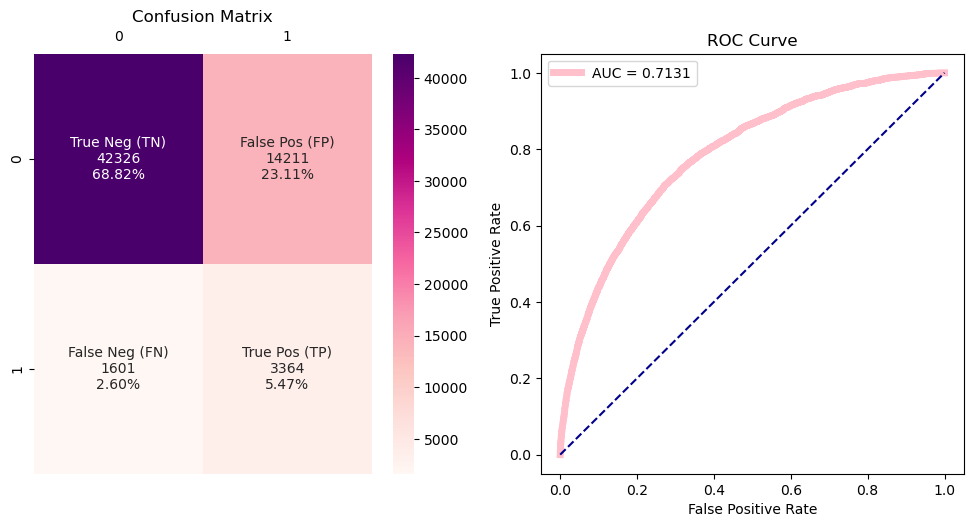

True negative =  42326
False positive =  14211
False negative =  1601
True positive =  3364
Le score personnelle de métier pour Light GBM with best params : 0.7170788451789017.



In [83]:
resultats_model3 = evaluation_model_without_GS(model, 'Light GBM with best params', 
                                               X_train, y_train, X_test, y_test,
                                               skfold, random_state, scoring)

In [84]:
display(resultats_model3)

,Modèle,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Light GBM with best params,0.713093,0.742903,0.191408,0.677543,0.298492,0.717079,337.809806


In [59]:
results_RF_LGBM = pd.read_csv('C:\\Users\\LEMuon\\Downloads\\P7_resultats_evaluation_RF_LGBM.csv')
display(results_RF_LGBM)

,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Random Forest,None,0.502009,0.919417,0.636364,0.004230,0.008403,0.557825,174.426400
1,Random Forest,class_weight,0.503342,0.919336,0.529412,0.007251,0.014306,0.558969,108.823515
2,Random Forest,SMOTE,0.532064,0.910328,0.296898,0.080967,0.127235,0.582646,406.368174
3,Light GBM,None,0.518373,0.920116,0.576923,0.039275,0.073543,0.572094,50.311849
4,Light GBM,class_weight,0.713410,0.733521,0.187356,0.689426,0.294642,0.716099,45.382068
5,Light GBM,SMOTE,0.518342,0.918539,0.450331,0.041088,0.075305,0.571856,212.335099


In [60]:
results_RF_LGBM = pd.concat([results_RF_LGBM, resultats_model3], ignore_index=True)
display(results_RF_LGBM)

,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps
0,Random Forest,None,0.502009,0.919417,0.636364,0.004230,0.008403,0.557825,174.426400
1,Random Forest,class_weight,0.503342,0.919336,0.529412,0.007251,0.014306,0.558969,108.823515
2,Random Forest,SMOTE,0.532064,0.910328,0.296898,0.080967,0.127235,0.582646,406.368174
3,Light GBM,None,0.518373,0.920116,0.576923,0.039275,0.073543,0.572094,50.311849
4,Light GBM,class_weight,0.713410,0.733521,0.187356,0.689426,0.294642,0.716099,45.382068
5,Light GBM,SMOTE,0.518342,0.918539,0.450331,0.041088,0.075305,0.571856,212.335099
6,Light GBM with best params,NaN,0.707888,0.745325,0.190523,0.663243,0.296013,0.712894,1342.488811


In [67]:
results_RF_LGBM['Best params']= ' '
results_RF_LGBM['Best params'][6] = ['learning_rate: 0.01, max_depth: -1, n_estimators: 500, num_leaves: 100, class_weight: balanced']
                                     
display(results_RF_LGBM)

,Modèle,Méthode_imbalance,roc_auc,accuracy,precision,recall,f1,score_pers,Temps,Best params
0,Random Forest,None,0.502009,0.919417,0.636364,0.004230,0.008403,0.557825,174.426400,
1,Random Forest,class_weight,0.503342,0.919336,0.529412,0.007251,0.014306,0.558969,108.823515,
2,Random Forest,SMOTE,0.532064,0.910328,0.296898,0.080967,0.127235,0.582646,406.368174,
3,Light GBM,None,0.518373,0.920116,0.576923,0.039275,0.073543,0.572094,50.311849,
4,Light GBM,class_weight,0.713410,0.733521,0.187356,0.689426,0.294642,0.716099,45.382068,
5,Light GBM,SMOTE,0.518342,0.918539,0.450331,0.041088,0.075305,0.571856,212.335099,
6,Light GBM with best params,NaN,0.707888,0.745325,0.190523,0.663243,0.296013,0.712894,1342.488811,"[learning_rate: 0.01, max_depth: -1, n_estimat..."


In [68]:
print(results_RF_LGBM['Best params'][6])

['learning_rate: 0.01, max_depth: -1, n_estimators: 500, num_leaves: 100, class_weight: balanced']


### 3.3.3 Features importance <a class="anchor" id="section3.3.3"></a> 

In [11]:
model = LGBMClassifier(random_state=random_state, n_jobs=-1, class_weight = 'balanced', learning_rate= 0.01,
                       max_depth=-1, n_estimators=500, num_leaves=31)

In [16]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

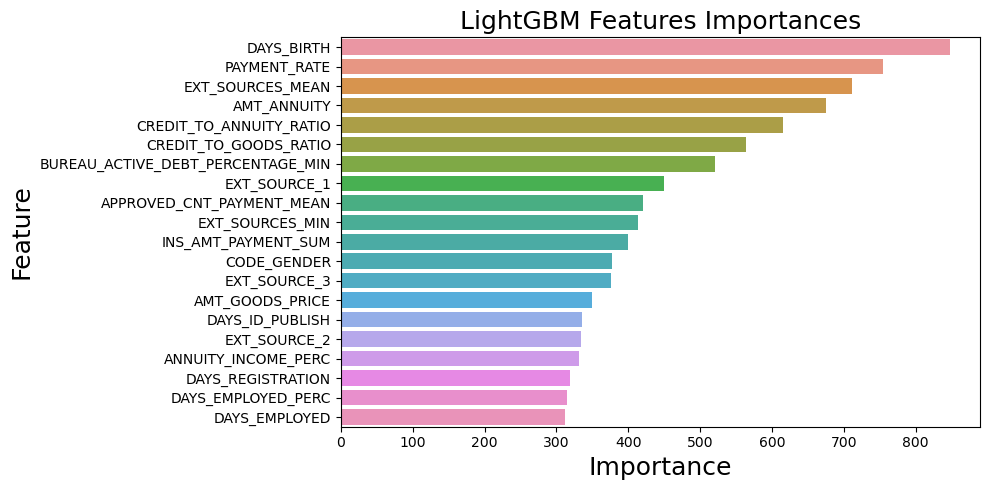

In [17]:
# Importance des variables

# Feature importance :
feature_importances = pd.Series(model.feature_importances_,
                                index=X_train.columns).sort_values(ascending=False)[0:20]

df_feature_importances = pd.DataFrame({'feature':feature_importances.index, 'importance':feature_importances.values})     

# Visualisation
plt.figure(figsize=(10, 5))
sns.barplot(x="importance", y="feature", data=df_feature_importances)
plt.title('LightGBM Features Importances', fontsize=18)
plt.xlabel('Importance', fontsize=18)
plt.ylabel('Feature', fontsize=18)
plt.tight_layout()

### 3.3.4 Interprétation avec SHAP <a class="anchor" id="section3.3.4"></a> 

Nous avons implémenté la méthode SHAP (**SHapley Additive exPlanations**) qui consiste à calculer la valeur de Shapley pour toutes les variables de tous les individus c’est-à-dire la moyenne de l’impact d’une variable (sur la sortie, donc la prédiction) pour toutes les combinaisons de variables possibles.

La somme des effets de chaque variable explique alors la prédiction.

In [18]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [35]:
#shap_values

In [36]:
# Shap_values uniquement pour la classe 1
#shap_values[1]

### Interprétation globale

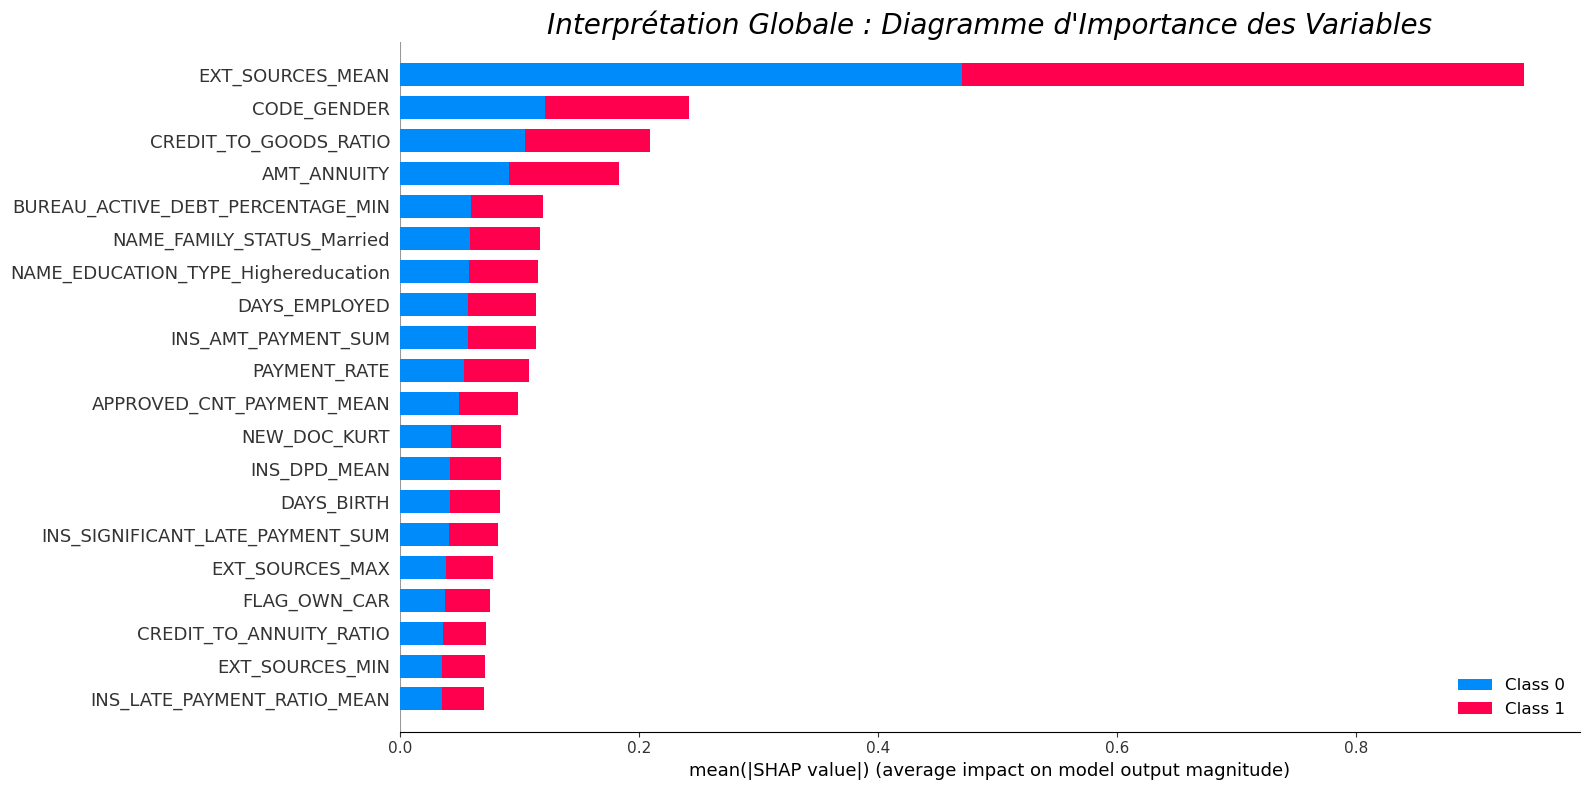

In [40]:
#To visualize the feature importance we need to use summary_plot method:
shap.summary_plot(shap_values, X_test, feature_names=data1.columns, plot_type="bar",
                  plot_size=(16, 8),
                  max_display=20,
                  show = False)

plt.title("Interprétation Globale : Diagramme d'Importance des Variables", fontsize=20, fontstyle='italic')
plt.tight_layout()
plt.show()

Le graphe ci-dessus représente les impacts des valeurs des variables importantes sur la prédiction.

Les variables en rouge contribuent le plus à une prédiction positive (dossier non remboursé), les variables en bleu contribuent le plus à une prédiction négative (dossier remboursé).

**SHAP** permet également une analyse globale.

En effet, en moyennant les valeurs absolues des valeurs de chaque variable (niveau local), on remonte à l’importance globale des variables.

L’importance des variables est calculée en moyennant la valeur absolue des valeurs de Shap.

Les caractéristiques sont classées de l'effet le plus élevé au plus faible sur la prédiction. Il prend en compte la valeur SHAP absolue, donc peu importe si la fonctionnalité affecte la prédiction de manière positive ou négative.

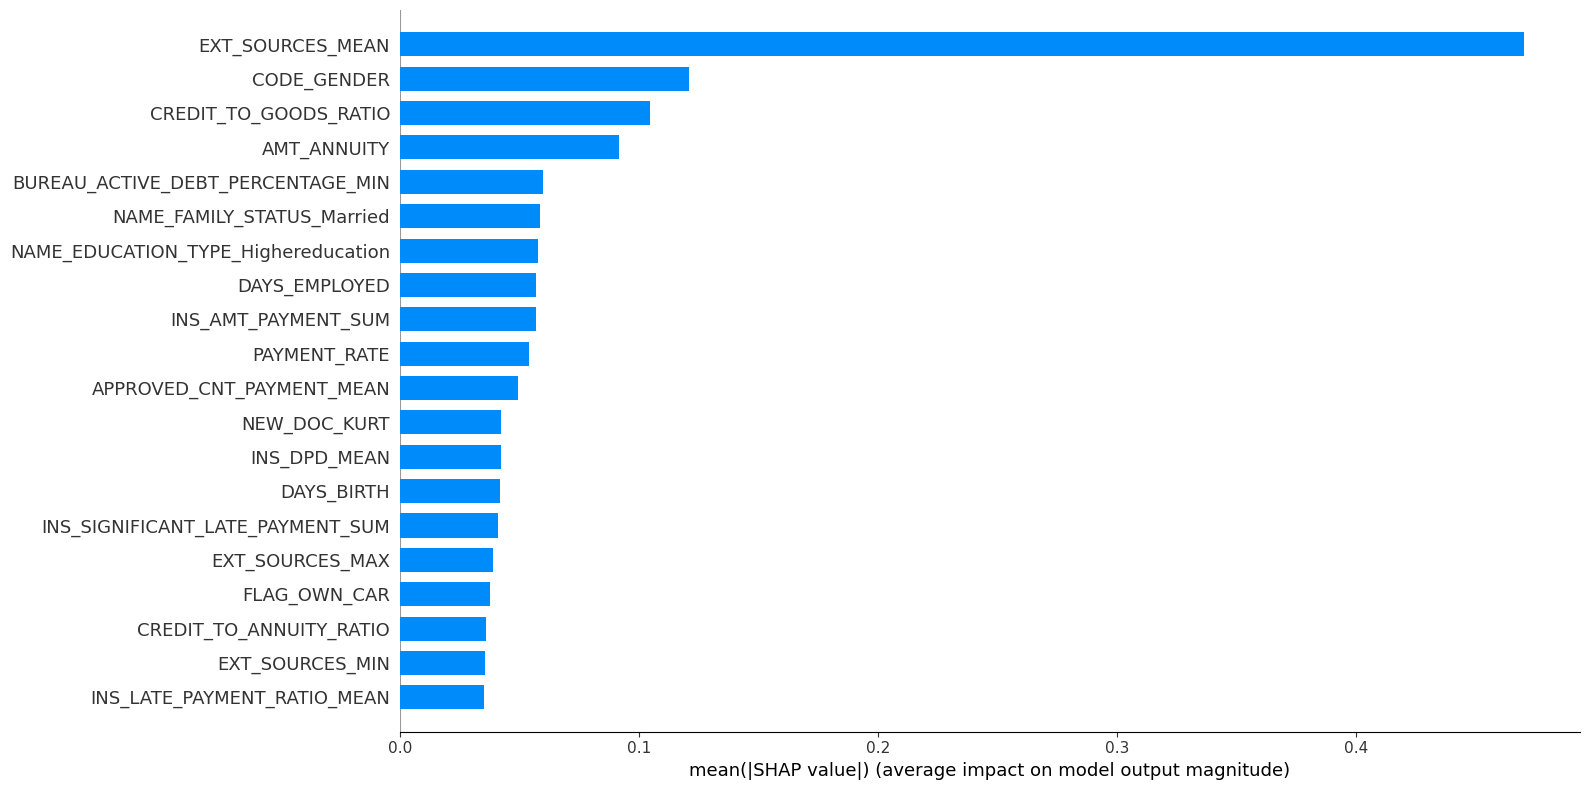

In [42]:
shap.summary_plot(shap_values[0], X_test, plot_type='bar',
                  plot_size=(16, 8),
                  max_display=20,
                  show = False)

### Impact de chaque caractéristique sur la prédiction
Le diagramme de valeurs SHAP ci-dessous indique également comment chaque caractéristique impacte la variable dépendante

Les valeurs de Shap sont représentées pour chaque variable dans leur ordre d’importance, chaque point représente une valeur de Shap (pour un client), les points rouges représentent des valeurs élevées de la variable et les points bleus des valeurs basses de la variable.

Dans le graphe ci-dessous, les dossiers sont représentés par des points dont la couleur varie en fonction de la valeur de la variable (petite à grande valeur = bleu à rouge).

Les points sont positionnés sur l’axe des abscisses selon leur valeur SHAP ce qui caractérise l’impact de la variable sur la prédiction.

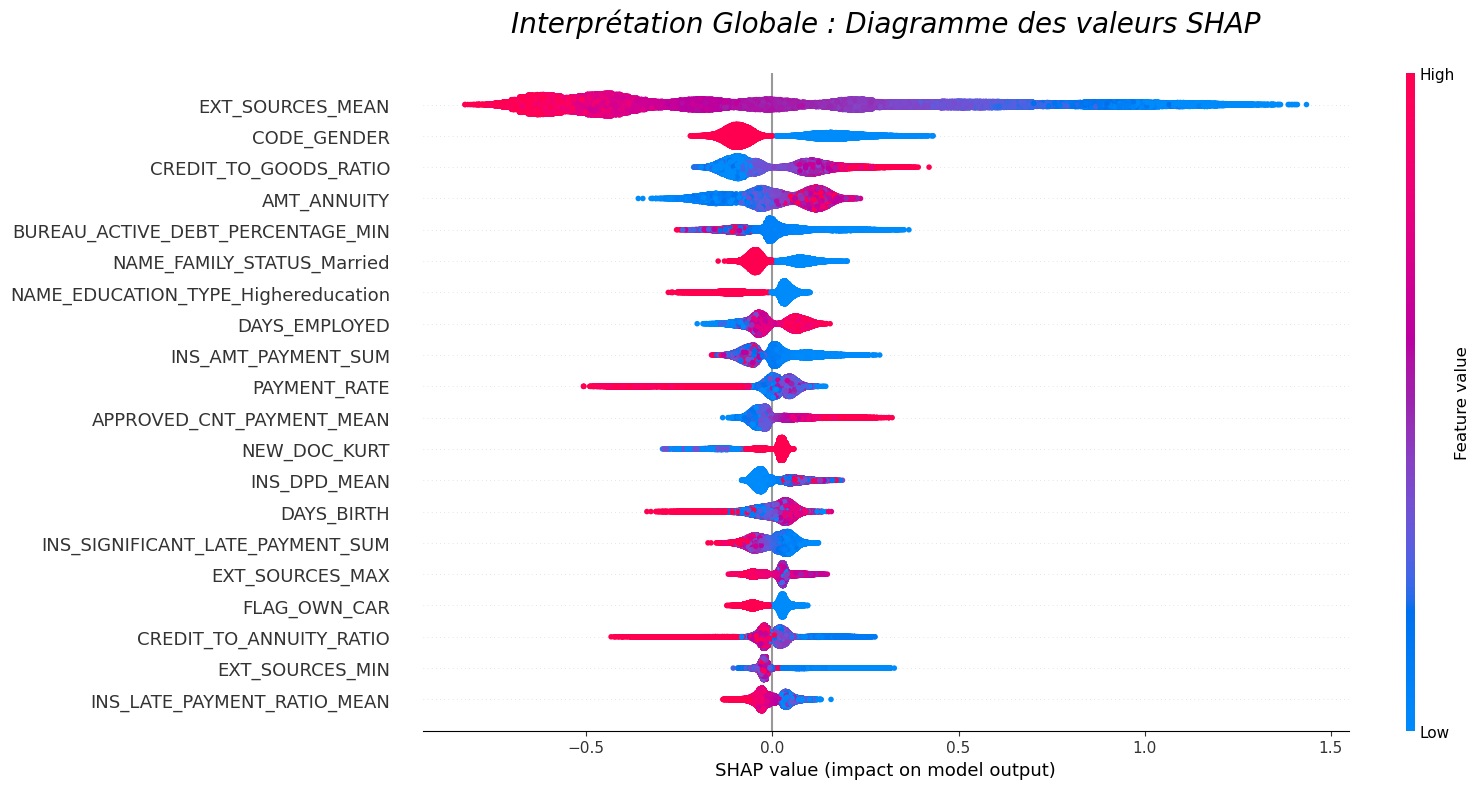

In [43]:
shap.summary_plot(shap_values[1], X_test,
                  plot_size=(16, 8),
                  max_display=20,
                  show = False)

plt.title("Interprétation Globale : Diagramme des valeurs SHAP\n", 
          fontsize=20, fontstyle='italic')
plt.tight_layout()
plt.show()

Plus la valeur du `EXT_SOURCES_MEAN` est faible (points de couleur bleue), et plus la valeur Shap est élevée et donc plus le modèle prédit que le client aura des difficultés de paiement.

Nous pouvons obtenir un aperçu plus approfondi de l'effet de cette fonctionnalité sur l'ensemble de données avec un graphique de dépendance.

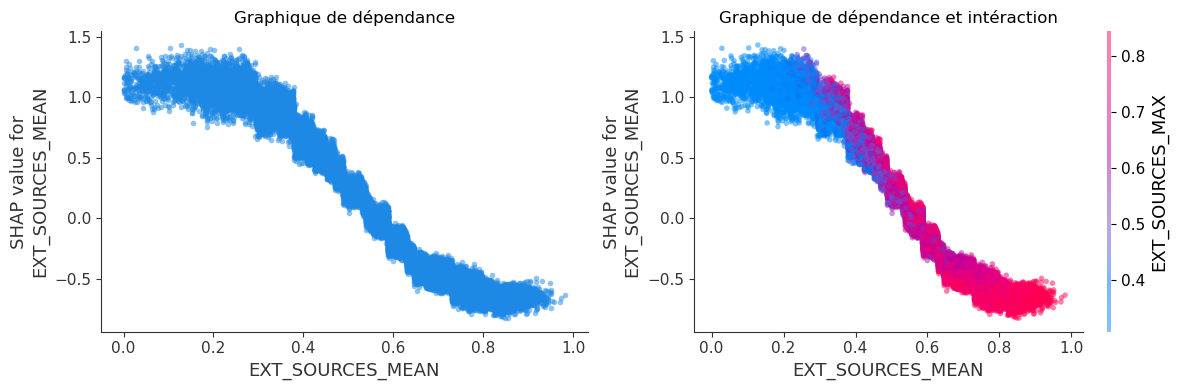

In [50]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(121)
shap.dependence_plot('EXT_SOURCES_MEAN', shap_values[1], X_test, 
                     interaction_index=None, alpha = 0.5,
                     ax=ax1, show = False)
ax1.title.set_text("Graphique de dépendance" )

ax2 = fig.add_subplot(122)
shap.dependence_plot('EXT_SOURCES_MEAN', shap_values[1], X_test, 
                     interaction_index='auto', alpha = 0.5, 
                     ax=ax2, show = False)
ax2.title.set_text("Graphique de dépendance et intéraction" )

plt.tight_layout()
plt.show()

Plus `EXT_SOURCES_MAX` par le client est faible (points de couleur bleue), plus la valeur Shap de `EXT_SOURCES_MEAN` est élevée et donc plus le modèle pédit que le client aura des difficultés de paiement.

### Interprétation locale du modèle
Pour comprendre et interpréter visuellement les résutats du modèle localement, c'est-à-dire pour une instance (ici un client) il existe trois alternatives: force plot, decision plot et waterfall plot.

Pour une instance, ces trois représentations sont redondantes, elles représentent l’information de manière très similaire. En même temps, certains éléments de ces graphiques sont complémentaires. En mettant côte à côte les trois, on comprend d’une manière plus intuitive le résultat. Le force plot est bon pour voir où se place le “output value” par rapport à la “base value”. Nous observons également quelles variables ont un impact positif (rouge) ou négatif (bleu) sur la prédiction et l’amplitude de cet impact. Le water plot permet aussi de voir l’amplitude et la nature d’impact d’une variable avec sa quantification. Il permet de voir également l’ordre d’importance des variables et les valeurs prises par chacune des variables pour l’instance étudiée. Le Decision plot permet d’observer l’amplitude de chaque changement, “une trajectoire” prise par une instance pour les valeurs des variables affichées.

On peut aussi représenter plusieurs instances en même temps avec le force plot et le decision plot.

Le force plot pour un ensemble d'instances peut être comparé au dernier niveau d’un dendrogramme. Les échantillons sont groupés par similarité ou par variable sélectionnée. Mais ce graphique est difficile à lire pour un échantillon aléatoire. Il est beaucoup plus parlant si nous représentons les cas contrastés ou avec une hypothèse derrière.

Le decision plot, pour un ensemble d’échantillons, devient vite encombrant si nous sélectionnons trop d’instances. Il est très utile pour observer ‘un écart de trajectoire’ ou des “trajectoires divergentes/convergentes” d’un groupe d’instances limité.

In [54]:
explainer_shap = shap.TreeExplainer(model)
shap_values2 = explainer_shap.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [56]:
# load JS visualization code to notebook
shap.initjs()

idx = 998
print("Client numero : ", X_test.iloc[idx, 0])
print("Model Prediction : Classe", y_pred[idx])
print(f"Il y a {y_proba[idx][1]:.1%} de risques que le client ait des difficultés de paiement")
print("__"*40)
shap.force_plot(explainer_shap.expected_value[1], 
                shap_values2[1][idx,:], 
                X_test.iloc[idx,:], 
                link='logit',
                figsize=(20, 8),
                ordering_keys=True,
                text_rotation=0,
                contribution_threshold=0.05)

Client numero :  1.0
Model Prediction : Classe 0.0
Il y a 12.6% de risques que le client ait des difficultés de paiement
________________________________________________________________________________


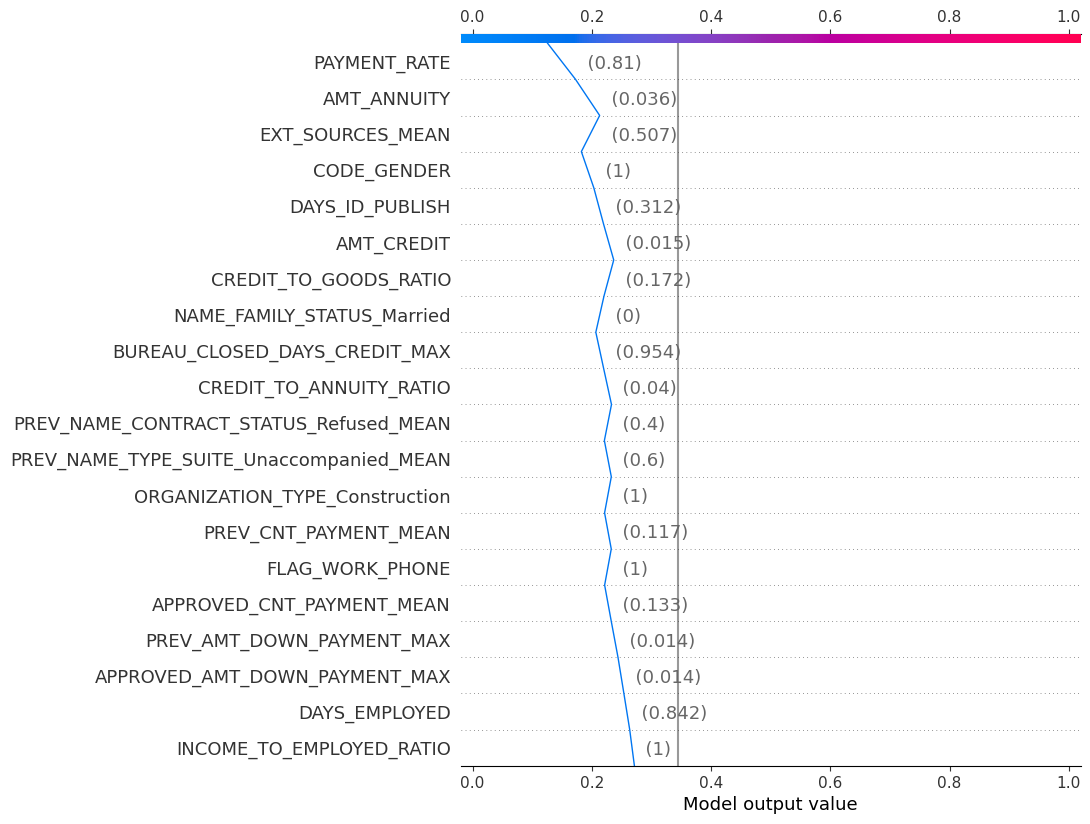

In [57]:
shap.decision_plot(explainer_shap.expected_value[1], 
                   shap_values2[1][idx,:], 
                   X_test.iloc[idx,:], 
                   feature_names=data1.columns.to_list(),
                   feature_order='importance',
                   #feature_display_range=slice(None, -15, -1),
                   link='logit')

### 3.3.5 Interprétation avec LIME <a class="anchor" id="section3.3.5"></a> 

In [72]:
import lime

from lime import lime_tabular

In [1]:
#explainer2 = lime_tabular.LimeTabularExplainer(X_train, mode = "classification", feature_names = data1.columns)
#explainer2

In [ ]:
# Sauvegarde du modèle
            if mod_dump_ == 1:
                joblib.dump(model, path_models+df_app_name+'_'+strat_+'_'+cls_model_version_+'_'+str(kf)+'.joblib')